##Import libraries

In [ ]:
#install huggingface
!pip install transformers

#install sentencepiece (tokenizer used by some language models---GPT, DeBERTa V2)
!pip install sentencepiece
!wget https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-06-09 18:10:19--  https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278779 (272K) [text/plain]
Saving to: ‘botchan.txt.1’

botchan.txt.1       100%[===================>] 272.25K  --.-KB/s    in 0.01s   

2023-06-09 18:10:19 (24.3 MB/s) - ‘botchan.txt.1’ saved [278779/278779]



In [ ]:
#install the version of sklearn that supports varimax rotation in factor analysis
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)


In [ ]:
#import libraries

#deep learning / NLP
import torch
from transformers import pipeline #HuggingFace library
from transformers import AutoTokenizer, AutoModel #AutoModelForMaskedLM
import sentencepiece

#basic operations on matrices
import numpy as np
import pandas as pd

#matrix factorization
from sklearn.decomposition import PCA, FactorAnalysis, KernelPCA
from sklearn.preprocessing import StandardScaler

#plotting results
import seaborn as sns
import matplotlib.pyplot as plt

#for helper functions
!pip install pynvml
from pynvml import *
import time
import gc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyyaml==5.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Define helper functions

In [ ]:
def load_model(model_name = "roberta"):
  model = AutoModel.from_pretrained(mask_fill_models[model_name][0], output_attentions = False)
  tokenizer = AutoTokenizer.from_pretrained(mask_fill_models[model_name][1], use_fast=False)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  memory_check()

  #grab the special mask token
  mask_token = tokenizer.mask_token

  return model, tokenizer, mask_token

In [ ]:
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [ ]:
#GPU memory fills up if careless about variables
#fcn to check memory
def memory_check(total = False):
  nvmlInit()
  h = nvmlDeviceGetHandleByIndex(0)
  info = nvmlDeviceGetMemoryInfo(h)
  if total == True:
    print(f'Total Memory = {round(info.total / 2**30, 2)} GB')
  print(f'Free Memory = {round(info.free / info.total,4)*100} %')

memory_check()

Free Memory = 98.32 %


In [ ]:
#this code lifted from: https://pretagteam.com/question/perform-varimax-rotation-in-python-using-numpy
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
  p, k = Phi.shape
  R = eye(k)
  d = 0
  for i in range(q):
    d_old = d
    Lambda = dot(Phi, R)
    u, s, vh = svd(dot(Phi.T, asarray(Lambda) ** 3 - (gamma / p) * dot(Lambda, diag(diag(dot(Lambda.T, Lambda))))))
    R = dot(u, vh)
    d = sum(s)
    if d_old != 0 and d / d_old < 1 + tol:
      print(f"Completed varimax iteration {i + 1}.")
      break
  return dot(Phi, R)

In [ ]:
def embed_w_batches(sentences, tokenizer, model, device, mask = True,
                    verbose = False,batch_size = 256):
  #start clock
  if verbose: tic()

  #empty GPU cache
  torch.cuda.empty_cache()

  #make sure batch size will not cause an out of memory error
  #currently very rough threshold
  #todo: do a memory check and inputs check then calculate appropriate batch size
  #if batch_size > 256:
  #  print("batch_size reset to 256")
  #  batch_size = 256

  def chunks(lst, n):
    for i in range(0, len(lst), n):
      yield lst[i:i + n]

  embedding = []
  for i, sentence_batch in enumerate(chunks(sentences, batch_size)):
    if verbose: print(f"Sample: {i*batch_size}")
    embedding += list(embed_sentences(sentence_batch, tokenizer, model, device, mask = mask, verbose = verbose))

  if verbose: toc()
  return np.array(embedding)

def embed_sentences(sentences, tokenizer, model, device, mask = True, verbose = False):
  inputs = tokenizer(sentences, return_tensors = "pt", padding = True).to(device)
  outputs = model(**inputs)
  embedding = outputs.last_hidden_state.cpu().detach().numpy()

  if mask == True:
    mask_idx = inputs["input_ids"] == tokenizer.mask_token_id
    mask_idx = mask_idx.cpu()
    #put some warning if there are no mask tokens
    embed_temp = []

    for i in range(embedding.shape[0]):
      embed_row = embedding[i,mask_idx[i],:].squeeze()
      if len(embed_row.shape)>1:
        embed_row = embed_row.mean(axis = 0)
      embed_temp += [embed_row]
    embedding = np.array(embed_temp)

  if mask == False:
    mask_idx = None
    #use CLS token
    embedding = embedding[:,0,:].squeeze()
    #could also take mean of all tokens

  if verbose: memory_check(total = False)

  #clean up the memory on GPU
  del inputs, outputs, mask_idx
  torch.cuda.empty_cache()

  return embedding

In [ ]:
def print_gpu_vars():
  for obj in gc.get_objects():
    try:
      if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
        print(type(obj), obj.size())
    except:
      pass

In [ ]:
def heatmap(corr_df, sig_figs = 2, title = False):
  corr_df = round(corr_df,sig_figs)
  xlabs = corr_df.columns
  ylabs = corr_df.index
  sns.set(rc={'figure.figsize':(len(xlabs)*0.7,len(ylabs)*0.6)})
  sns.heatmap(corr_df.abs(), annot = corr_df.values, yticklabels=ylabs, xticklabels=xlabs)
  if title:
    plt.title(title, fontsize = 14)
  plt.show()

In [ ]:
def factorize(vec, n_components = 5, method = "FA",
              EV = True, scaler = True, n_EV = 10):

  ###scale data###
  if scaler:
    scaler = StandardScaler(with_std = True)
    vec = scaler.fit_transform(vec)

  ###find eigenvalues###
  #included w/ if statement in case n>d (as in allport), and method is PCA (the large corr matrix need not be calculated twice)
  if EV == True:
    #check to see if vec is square
    if vec.shape[-1] != vec.shape[0]:
      corr = np.corrcoef(vec)
    else:
      corr = vec
    #calculate eigs
    EV = np.linalg.eig(corr)[0]
    #norm
    EV = EV[:n_EV]/np.sum(EV)

  ###factorize data###

  if method == "PCA":
    reducer = PCA(n_components = n_components)
    factors = reducer.fit_transform(vec)
    if len(EV) == 1:
      EV = reducer.explained_variance_ratio_

  elif method == "FA":
    reducer = FactorAnalysis(n_components = n_components, rotation = "varimax")
    reducer.fit(np.corrcoef(vec)) #reducer.fit(np.corrcoef(vec))
    factors = reducer.components_.T

  elif method == "kernel":
    gamma = 1/(1024*vec.var()) #recommended scaling from sklearn.svm.SVC documentation
    reducer = KernelPCA(n_components = n_components, kernel = "rbf", gamma = gamma)
    factors = reducer.fit_transform(vec)

  EV = np.array([np.abs(val) for val in EV])#find the magnitude if complex
  #EV = EV.abs() #why not just this?

  return factors, reducer, EV

In [ ]:
def plot_words(df, xlim = 22, ylim = 16, col_names = None, words = None,
               title = "Factor Analysis of Adjectives"):

  if words == None:
    words = df.index.astype(str).tolist()

  if col_names == None:
    col_names = df.columns.astype(str).tolist()

  sns.set_style("whitegrid", {'axes.grid' : False})

  for i in range(int(len(col_names)/2)):
      x = df.iloc[:,i*2]
      y = df.iloc[:,i*2 + 1]
      plt.figure(figsize=(xlim,ylim)) #note this is not square. Easier to read, not to scale
      plt.scatter(x,y)
      plt.xlabel(col_names[i*2], fontsize = 24)
      plt.ylabel(col_names[i*2 +1], fontsize = 24)
      plt.title(title, fontsize = 24)
      for j,word in enumerate(words):
          plt.text(x[j], y[j], word.lower(), fontsize=10)
      plt.show()

In [ ]:
def topk_words(df, k = 10, verbose = True):
  word_lists = {}
  for col in df.columns:
    a = df.sort_values(by = col, ascending = False)
    col_words = [a[col].iloc[:k].index.to_list()]
    a = df.sort_values(by = col, ascending = True)
    col_words += [a[col].iloc[:k].index.to_list()]
    word_lists[col] = col_words

  #make the dict a df
  topk_df = pd.DataFrame.from_dict(word_lists, orient = "columns").T
  topk_df.columns = ["Positive Loading", "Negative Loading"]

  if verbose:
    with pd.option_context('display.max_colwidth', None):
      display(topk_df)

  return topk_df

In [ ]:
def nearest_neighbors(df, term, k= 5):
  dist = df - df.loc[term]
  dist = dist.pow(2)
  dist = dist.sum(1).pow(0.5)
  neighbors = dist.sort_values(ascending = True).iloc[1:k+1]
  return neighbors.index.tolist()

In [ ]:
def make_sentences(adjectives, subset = False): #subset = [1,3,5,6]

  q1 = [f"Those close to me say I have a {mask_token}{mask_token} and {word} personality." for word in adjectives]
  q2 = [f"The girl's disposition became more {mask_token}{mask_token} and {word} as the years passed." for word in adjectives]
  q3 = [f"I tend to be {mask_token}{mask_token} and {word}." for word in adjectives]
  q4 = [f"My inlaws seem like {mask_token}{mask_token} and {word} folks." for word in adjectives]
  q5 = [f"Met this guy and he's so {mask_token} and {word}. You would not believe!" for word in adjectives]
  q6 = [f"My arch enemy's personality: {mask_token}, {mask_token} and {word}." for word in adjectives]
  q7 = [f"A woman of contrasts: at times {mask_token}{mask_token}{mask_token}{mask_token} and at others perfectly {word}." for word in adjectives]
  q8 = [f"When he felt most authentic he would adopt an {mask_token}{mask_token} and {word} persona." for word in adjectives]

  Q_list = [q1, q2, q3, q4, q5, q6, q7, q8]
  if subset:
    Q = []
    for i in subset:
      Q += Q_list[i-1]
  else:
    Q = q1 + q2 + q3 + q4 + q5 + q6 + q7 + q8

  return Q

# Introduction

The essence of the Lexical Hypothesis is that personality structure is embedded in natural language. Traditionally, this structure has been interrogated by representing personality adjectives as vectors, with each value reflecting the extent to which each participant agrees the word describes her. Many decades of [prior research](https://doi.org/10.1037/0003-066X.48.1.26) based on this approach has concluded in favor of five latent factors of personality, and these claims have led to [widespread adoption](https://doi.org/10.1016/j.paid.2020.110002) of the "Big Five" framework among personality psychologists. Recently developed Deep Learning models offer a more powerful way to vectorize words. They are trained on corpuses that include most of the books ever written as well as much of the text on the internet, and they have come to dominate most performance [benchmarks](https://super.gluebenchmark.com/leaderboard) in natural language processing.

This notebook reproduces the experiments in [Deep Lexical Hypothesis:](https://psyarxiv.com/gdm5v/) Identifying personality structure in natural language. Analysis include:

1. Re-analysis of data reported by [Saucier and Goldberg (1996)](https://doi.org/10.1002/(SICI)1099-0984(199603)10:1<61::AID-PER246>3.0.CO;2-D) in order to recover and re-evaluate the reported structure.
2. Analysis of the same personality descriptors used by Saucier and Goldberg (1996) with a language model, DeBERTa.
3. Sensitivity analyses to consider the effects of changing:
* Adjective set
* Query method
* Language model

As discussed in the manuscript, Deep Learning models are similar to traditional approaches of psycholexical analysis in that they can only produce a _descriptive_ framework of personality structure, but the two-three factor structure reported here yields a  _theoretically_ satisfying framework that aligns with the work of many other researchers (e.g., Skinner, Maslow, Gray, Block, Higgins). It also approximates the empirical findings of [Digman](https://doi.org/10.1037/0022-3514.73.6.1246) (who describes similar meta-traits that exist on top of the Big Five) along with the more recent generalizability studies of [Saucier, Thalmayer et al.](https://doi.org/10.1111/jopy.12028) and [De Raad et al.](https://doi.org/10.1002/per.1953)

# Study 1: Reanalysis of Saucier and Goldberg #




The primary aim of this study is to reproduce the structure of the Big Five using one of the foundational sets of personality descriptors. A secondary aim is to describe the structure of this same set when extracting different numbers of factors (e.g., 2, 3, 4, and 6 factors). These aims are motivated by the need for comparators in Study 2 where we aim to evaluate the utility of NLP methods for research on the lexical structure of personality. Before beginning with the reproducibility analyses, we explain why the 435-term set analyzed in [Saucier and Goldberg (1996)](https://doi.org/10.1002/(SICI)1099-0984(199603) is particularly useful as a baseline for comparison.

##Rationale##

At the time of the current study (mid-2021), S&G 1996 was considerably less well cited (365 citations on Google Scholar) than similar empirical, lexical studies of English-language personality descriptors published by Goldberg independently in [1990](https://doi.org/10.1037/0022-3514.59.6.1216) (9,013 citations) and [1992](https://doi.org/10.1037/1040-3590.4.1.26) (7,097 citations), [Hofstee, De Raad, & Goldberg](https://doi.org/10.1037/0022-3514.63.1.146) in 1992 (1,194 citations), or Saucier independently in [1994](https://doi.org/10.1207/s15327752jpa6303_8) (2,275 citations). This is unsurprising in the sense that these earlier studies serve as more canonical references for the lexically-derived Big Five structure, but it *is* surprising in the sense that this 1996 publication is better suited for subsequent replication analyses.

We make this claim for several reasons, both practical and theoretical. The first of these is simply due to the scope of the personality descriptor set. Though larger sets exist (i.e., slightly larger in Goldberg [1990] or much larger -- but with many fewer ratings -- in [Ashton, Lee & Goldberg](https://doi.org/10.1037/0022-3514.87.5.707) [2004]), the 435 items in this set allow for more exploratory analyses than the pre-structured Big Five Factor Markers (Goldberg, 1992) or the "mini-markers (Saucier, 1994). Related to this point, S&G 1996 includes a wonderfully detailed table of factor loadings for every one of the 435 adjectives included in the personality-descriptor set. This is emblematic of the transparency, thoroughness, and care shown by Goldberg, Saucier, and others working in the empirically-driven psycholexical literature. Though the other papers listed above (among many others from this era) contain similar levels of detail, none show the loadings for all the terms in five factor space. It was not common, at that time, to make use of open data repositories and supplementary materials, so the inclusion of this information as part of the manuscript is invaluable. This is because it is possible, even without the underlying data, to (imperfectly) estimate the covariance matrix by multiplying the loadings matrix and its transpose.

Another reason this work is well-suited for replication is that the sample of participants was (a) large (*N* = 899) and (b) influential in one of the earlier Big Five reports ([Goldberg, 1990](https://doi.org/10.1037/0022-3514.59.6.1216)). Relative to the canonical Big Five paper (reporting on different analyses; Goldberg, 1990), these ratings represent all of the data used in Study 1, about 7/8ths of those used in Study 2, and about 3/4ths of those used in Study 3. They include a relatively balanced combination of self-report (*N* = 507) and peer-report (*N* = 392) ratings provided by students (>90% undergraduates) at the University of Oregon in the 1980s. Though lacking in diversity by current standards, the sample was impressively large for its time and the Big Five framework developed on the basis of these data influenced many subsequent personality assessment models, including the 100-item IPIP measure of the Big Five Factor Markers ([Goldberg, 1999](https://projects.ori.org/lrg/PDFs_papers/A%20broad-bandwidth%20inventory.pdf)), the Big Five Aspect Scales ([DeYoung et al., 2007](https://doi.org/10.1037/0022-3514.93.5.880)), and the Big Five Inventory 2 ([Soto & John, 2017](https://doi.org/10.1037/pspp0000096)).

Perhaps the most important reason stems from the rationale underlying the use of these 435 terms specifically. As [Goldberg](https://doi.org/10.1037/0022-3514.59.6.1216), [Saucier](https://doi.org/10.1037/0022-3514.73.6.1296), [Block](https://doi.org/10.1037/0033-2909.117.2.187) and many others have acknowledged, factor analytic output is strongly dependent on the data/variables being factored. Virtually all of the lexical work leading to empirical identification the Big Five was based on data collected using subsets of the 1,710 terms in the 'Norman-Goldberg' set of trait-descriptors. These 1,710 terms are, more or less, a subset of the 2,797 terms previously identified by [Norman](https://files.eric.ed.gov/fulltext/ED014738.pdf) and colleagues, which are (again, more or less) a subset of the roughly 18,000 terms identified by [Allport and Odbert](https://doi.org/10.1037/h0093360). See [Goldberg, 1982](https://projects.ori.org/lrg/PDFs_papers/AcetoZombie.pdf) for a more detailed history. These large pools of personality descriptors pose a practical challenge because participants don't want to provide ratings on thousands -- or even hundreds -- of terms.

Predictably, the procedures used to "winnow and cull" these terms were cited as a concerning weakness by a prominent Big Five contrarian ([Block, 1995](https://doi.org/10.1037/0033-2909.117.2.187)), despite being described in considerable detail by Goldberg and others across the many publications listed above. A wide range of criteria were used to reduce the set of terms including judgments of ambiguity, difficulty, colloquiality, the degree of formal adoption (i.e., slanginess), and -- two of the most important criteria -- *evaluativeness* and *association with gender*. In fairness to Block and other critics, concerns about the criteria used to select relevant terms have persisted. For example, subsequent claims about the superiority of six-factor solutions depend on the inclusion of evaluative terms that convey important social information (note also that Saucier and Goldberg have both contributed substantially to this subsequent work). Comments about the influence of gendered terms will be discussed again later.

Concerns about these variable selection procedures relate to S&G 1996 because Saucier and Goldberg explicitly mention the criticism as motivation for the use of these 435 terms. As the authors state:

> "What comes out of a factor analysis depends largely on what goes into it, and Block (1995) has pointed to the hazards of experts inadvertently ‘prestructuring’ their data sets. If such prestructuring were to occur in lexical studies, it would be exhibited partly in the retention of certain variables despite their low frequency of use in everyday transactions; in other words, the expert may add certain ‘expert variables’, or cluster the variables in a biased manner, and thereby affect the results. One useful corrective for this inadvertent trend is to collect data on the familiarity of the terms from a sample of judges. Eliminating the less familiar terms should skim off the ‘expert’ variables and reduce the potential for bias in variable selection.

> If finding the Big Five is dependent on investigators’ prestructuring their data sets, as Block (1995) has suggested, the Big Five should not emerge clearly to the extent that variable selection is left in the hands of judges other than the investigator, and there is no clustering of terms. In this study, we test this hypothesis. We delineate the most familiar subset within the sets of 492 and 540 adjectives, and examine the factor structure of this unclustered subset. If the ‘expert-bias hypothesis’ is correct, the Big Five factor structure will be less clear in this subset than in the larger sets that contain possible ‘expert bias’."  (p. 63, Saucier & Goldberg, 1996)

The 435 terms were selected by Saucier and Goldberg from a larger set of 492 after having been rated by 25 individuals using a 10 point scale of familiarity. Scores ranged from 0 to 9 with those terms having an average rating of 3.25 or higher being retained. These raters were not overlapping with those who provided self- and peer-ratings but they were also undergraduates attending university in the western U.S. To be clear, the exclusion of terms that are empirically determined to be unfamiliar does not preclude the prospect of "expert bias" with respect to the other criteria used to winnow the pool down from 1,710 to ~500, but it is better than including terms that are known to be unfamiliar. It's a start.

To summarize, our rationale for reanalyzing S&G 1996 is based on (a) the relatively large size and unstructured nature of the descriptor set, (b) the transparent presentation of prior results (making reanalysis feasible and straightforward), (c) the characteristics of the sample (its large size, good mix of self- and peer-ratings, and lasting influence on Big Five research), and (d) we expect these 435 terms to be somewhat less biased than other subsets from the same era because they were empirically selected (on the basis of familiarity) in response to concerns about variable selection procedures.

###Method###

#### **Participants, Measures, and Procedure** ####

As the primary aim of Study 1 is to reproduce the structure of the Big Five using *existing* data, readers are referred to S&G 1996 for details about the data. In brief, the 435 personality descriptors were chosen from larger sets of terms on the basis of familiarity ratings by 25 raters who were similar in age and education level to the 583 unique respondents who provided self-ratings (*N* = 507) and/or peer-ratings (*N* = 392). The raters were mainly undergraduates, except for a small number of law students. All of the terms were English and the data were collected using paper forms. Response options varied within the sample (7 or 8), ranging from "extremely inaccurate" to "extremely accurate". None of the ratings contained missing data.

#### **Analyses** ####

Note that the Results reported in the primary manuscript are based on the actual data used in S&G 1996. We are grateful to Lew Goldberg and Gerard Saucier for providing us access to these data, which were not publicly available at the time this work was submitted for peer review. Upon receipt, the self- and peer-report ratings had already been ipsatized in order to address the differences in response options and to reduce the effect of differences in response style across raters.

The first step is to derive the covariance matrix from the ipsatized ratings. To reproduce the five factor (component) solutions, 5 components are extracted from the covariance matrix using principal components analysis with orthogonal rotation (varimax) as described in S&G 1996. Based on this solution, we will report on differences in the magnitudes of the item-level loadings and the eigenvalues relative to the prior findings. We also generate tables of the terms with the highest component loadings; one table each for the 10 most positive and 10 most negative (primary) loadings for each component.

To generate comparators for other levels of extraction, the principal component analyses are then repeated with extractions of 2, 3, 4, and 6 components. The content of the components in these solutions is indicated by similar tables of positive and negative loadings.
**[DMC: May need to add text here to go further... for example, if you want to talk about rotations other than varimax.]**

The analyses shown below are conducted using the [*scikit-learn*](https://scikit-learn.org/stable/) package in Python, but the R script provided **here** shows how the same analyses can be conducted using the [*psych*](http://personality-project.org/r/psych/) package. **[DMC: Andrew, can you post and link to the PDF I sent you?]**


### Results ###

The analytic procedures described above are carried out below.
**[DMC: Andrew to update the code below.]**

##Load and Factorize S&G data

In [ ]:
#load the survey results
df = pd.read_table("https://raw.githubusercontent.com/andcut/DeepLexicalHypothesis/main/lab_ratings2.csv", sep = ",", dtype = float).T
df.drop(labels = "Unnamed: 0", axis = 0, inplace = True)
df.dropna(axis = "columns", inplace = True)
cols_survey = ["subject_" + str(col+1) for col in list(df.columns)]
df.columns = cols_survey
df.sort_index(inplace = True)

#load The Big Five loadings on 435 words (reported by S&G)
df_435 = pd.read_table("https://raw.githubusercontent.com/andcut/DeepLexicalHypothesis/main/435self1996.csv", sep = ",", index_col = "word")
cols_big5 = list(df_435.columns)
df_435 = df_435.astype(float)
df_435.sort_index(inplace = True)
adj_435 = np.array([word.lower() for word in df_435.index])

#make this version map to what R reads
SG_error_map = {
    "nosey": "nosy",
    "easy-going": "easygoing",
    "naïve" : "naive"
}

for i, word in enumerate(adj_435):
  if word in SG_error_map.keys():
    adj_435[i] = SG_error_map[word]

df_435.index = adj_435

#combine the two
df = df.join(df_435)

The eigenvalues of the first 5 PCs:
[0.07112671 0.0579985  0.04112213 0.02930881 0.02469337 0.01548537
 0.01512206 0.01277996 0.01087764 0.00981906]


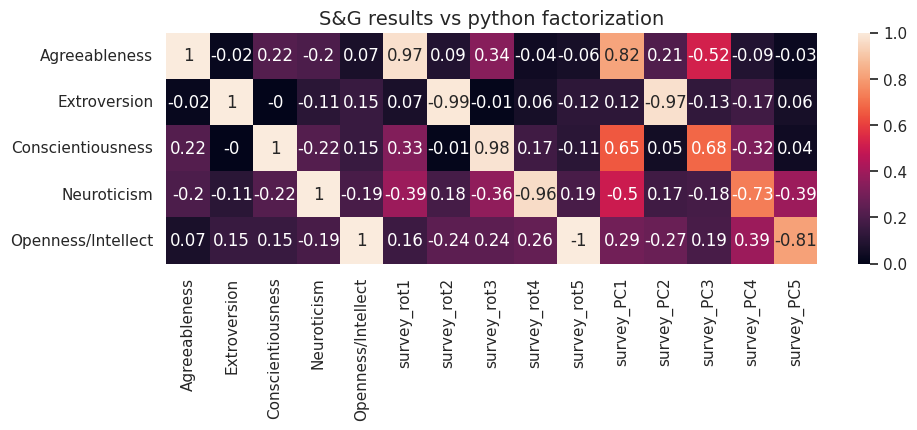

In [ ]:
# factorize the S&G data, extracting 5 components
# first with varimax rotation

n = 5
cols_survey_rotated = ["survey_rot" + str(i+1) for i in range(n)]
vec, reducer, ev_survey = factorize(df[cols_survey].dropna(), scaler = False,
                             method = "FA", n_components = n)
df[cols_survey_rotated] = vec

print(f"The eigenvalues of the first {n} PCs:")
print(ev_survey)

#now use PCA
n = 10
cols_survey_pc = ["survey_PC" + str(i+1) for i in range(n)]
vec, reducer, ev = factorize(df[cols_survey].T.corr(), scaler = False,
                             method = "PCA", n_components = n)
df[cols_survey_pc] = vec

corr = df[cols_big5 + cols_survey_rotated + cols_survey_pc[:5]].corr().loc[cols_big5, cols_big5 + cols_survey_rotated + cols_survey_pc[:5]]
heatmap(corr, title = "S&G results vs python factorization")

In [ ]:
df[cols_big5 + cols_survey_rotated + cols_survey_pc].to_csv("study1.csv")

The first five columns are included to show the Big Five, as they are reported, are not orthogonal due to the varimax rotation. So a perfectly diagonal matrix is not expected between our factorization and the reported Big Five (even if the reconstruction is perfect). Using varimax rotation, the digonal correlates >0.95 with S&G's results. FA1 is more correlated with Conscientiousness and Neuroticism than is Agreeableness. This could be because of different stopping proceedures during varimax rotation. Compute is much cheaper now, so tolerances are set quite low which leads to more rotation from the PCA solution. PCA recovers quite a different structure. In fact, the first two columns look like Digman's Alpha and Beta. More on that later.

Having demonstrated that the factorization tools in python can reproduce previously published results, we move to derive these factors using different data.

In [ ]:
_ = topk_words(df[cols_survey_rotated + cols_survey_pc[:5]], k= 20)

,Positive Loading,Negative Loading
survey_rot1,"[kind, sympathetic, cooperative, warm, understanding, patient, courteous, considerate, helpful, tolerant, polite, respectful, sincere, pleasant, charitable, compassionate, trustful, peaceful, agreeable, cordial]","[antagonistic, harsh, cold, rude, abusive, egotistical, inconsiderate, quarrelsome, unsympathetic, belligerent, scornful, bitter, abrupt, insincere, negativistic, cranky, combative, coarse, greedy, faultfinding]"
survey_rot2,"[shy, silent, withdrawn, introverted, timid, quiet, bashful, reserved, unaggressive, inhibited, unsociable, meek, passive, uncommunicative, restrained, dull, bland, submissive, melancholic, sedate]","[extroverted, aggressive, talkative, assertive, bold, sociable, social, verbal, confident, outspoken, dominant, daring, magnetic, communicative, spirited, enthusiastic, energetic, assured, uninhibited, rambunctious]"
survey_rot3,"[organized, responsible, precise, thorough, self-disciplined, practical, efficient, systematic, dependable, orderly, reliable, logical, steady, concise, consistent, careful, decisive, exacting, prompt, mature]","[disorganized, haphazard, careless, impractical, disorderly, inconsistent, unreliable, inefficient, illogical, absent-minded, immature, scatterbrained, negligent, erratic, undependable, reckless, indecisive, sloppy, unstable, lazy]"
survey_rot4,"[unemotional, masculine, unexcitable, relaxed, undemanding, patient, courageous, insensitive, brave, easygoing, informal, passionless, confident, consistent, assured, steady, tolerant, rough, unaffectionate, tough]","[emotional, touchy, moody, temperamental, jealous, fretful, possessive, envious, feminine, irritable, sentimental, nervous, self-pitying, fearful, sensitive, anxious, impatient, high-strung, insecure, excitable]"
survey_rot5,"[simple, conventional, traditional, unintellectual, uninquisitive, shallow, pompous, surly, dependent, patronizing, unintelligent, conservative, vindictive, ignorant, unscrupulous, inarticulate, submissive, pretentious, happy-go-lucky, unimaginative]","[intelligent, intellectual, complex, philosophical, smart, unconventional, nonconforming, deep, knowledgeable, insightful, bright, innovative, ingenious, analytical, introspective, contemplative, inquisitive, perceptive, articulate, inventive]"
survey_PC1,"[cooperative, responsible, reliable, patient, helpful, reasonable, dependable, respectful, polite, considerate, courteous, understanding, steady, kind, trustful, sincere, peaceful, warm, mature, self-disciplined]","[inconsiderate, antagonistic, rude, negativistic, cranky, abusive, quarrelsome, greedy, unreliable, bitter, irritable, haphazard, egotistical, grumpy, negligent, inconsistent, scornful, insincere, harsh, cold]"
survey_PC2,"[shy, timid, silent, bashful, quiet, withdrawn, introverted, unaggressive, reserved, inhibited, meek, passive, unsociable, submissive, restrained, uncommunicative, dull, bland, cowardly, melancholic]","[aggressive, extroverted, bold, assertive, talkative, verbal, confident, outspoken, dominant, sociable, daring, social, uninhibited, assured, magnetic, forceful, domineering, spirited, energetic, unrestrained]"
survey_PC3,"[precise, logical, thorough, organized, stern, exacting, firm, systematic, cold, efficient, unemotional, decisive, self-disciplined, practical, concise, consistent, orderly, impersonal, unsympathetic, strict]","[gullible, disorganized, scatterbrained, sympathetic, illogical, emotional, indecisive, haphazard, careless, affectionate, impulsive, feminine, sentimental, impractical, inefficient, absent-minded, inconsistent, warm, disorderly, happy-go-lucky]"
survey_PC4,"[unexcitable, unemotional, informal, masculine, undemanding, unconventional, disrespectful, nonconforming, sloppy, disorderly, unassuming, impolite, tolerant, disorganized, inefficient, nonreligious, aimless, patient, unaffectionate, insensitive]","[emotional, possessive, touchy, sentimental, jealous, anxious, excitable, orderly, temper

#Study 2: NLP factorization using same adjectives
The idea developed in this paper is that the dimensionality reduction on person-adjective matrices is an exercise in making word vectors. Instead of building those word vectors from surveys, they can be built from open source language models. The steps are:

1.   Use a language model to describe each word in 1024 dimensions
2.   Factor analysis of the 435x1024 matrix
3.   Compare this to the Big Five

##Load Language Model

In [ ]:
##load language model##
#thousands of models on https://huggingface.co/models?
#Here are a few suggestions to start with
#this dictionary includes the model nickname, file name on huggingface, and the suggested batch size

models = {
    #"name" : ["model-filename-on-huggingface", "tokenizer-file-name", suggested_batch_size],
    "bert-l" : ["bert-large-uncased", "bert-large-uncased", 256], #worse than roberta, but still does well. Also try bert-large-uncased-whole-word-masking
    "bert-b" : ["bert-base-uncased", "bert-base-uncased", 512], #doesn't recover Conscientiousness
    "bert-whole-word": ["bert-large-uncased-whole-word-masking", "bert-large-uncased-whole-word-masking", 256],
    "ernie" : ["nghuyong/ernie-2.0-en", "nghuyong/ernie-2.0-en", 256],
    "albert": ["albert-base-v2", "albert-base-v2", 512],
    "tweet" : ["vinai/bertweet-large","vinai/bertweet-large", 256],
    "tiny" : ["haisongzhang/roberta-tiny-cased", "haisongzhang/roberta-tiny-cased", 512], #quite bad results
    "muppet" :["facebook/muppet-roberta-large",'roberta-large', 256],
    "roberta-l" :["roberta-large",'roberta-large', 256],
    "deberta-xl-mnli" :["microsoft/deberta-xlarge-mnli","microsoft/deberta-xlarge-mnli",64],
    "deberta-xl" : ["microsoft/deberta-xlarge", 'roberta-large', 64],
    "deberta-l" : ["microsoft/deberta-large", 'roberta-large', 128],
    "deberta-b" : ["microsoft/deberta-base", 'roberta-base', 512],
    "distil" : ["distilroberta-base", "roberta-base", 256], #distilled version of roberta, poor performance
    "xlm" : ["xlm-roberta-large", "xlm-roberta-large", 64], #multilingual model
    "bert-discharge" : ["emilyalsentzer/Bio_Discharge_Summary_BERT","emilyalsentzer/Bio_Discharge_Summary_BERT", 512], #poor performance
    "bert-clinical" : ["emilyalsentzer/Bio_ClinicalBERT", "emilyalsentzer/Bio_ClinicalBERT", 512],
    "pubmed" : ["microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext", "bert-base-uncased", 512], #poor performance
    "mp-net" : ["microsoft/mpnet-base", "microsoft/mpnet-base", 256], #works
    "struct" : ["bayartsogt/structbert-large","bayartsogt/structbert-large", 256],
    "bigbird" : ["google/bigbird-roberta-large","roberta-large", 64],
    "funnel" : ["funnel-transformer/large-base", "funnel-transformer/large-base",64],
    "toxic" : ["unitary/toxic-bert", "unitary/toxic-bert", 256],
    "electra" : ["google/electra-large-discriminator","google/electra-large-discriminator", 256],
    "bort" : ["amazon/bort", "amazon/bort", 1024], #doesn't work
    "span" : ["SpanBERT/spanbert-large-cased", "SpanBERT/spanbert-large-cased", 256], #works
    "splinter" : ["tau/splinter-base-qass", "tau/splinter-base-qass", 256],
    "baby" : ["phueb/BabyBERTa", "phueb/BabyBERTa", 512], #sadly tokenizer doesn't work.
    "psych" : ["nlp4good/psych-search", "nlp4good/psych-search", 256],
    "dialogue" : ["microsoft/DialogRPT-human-vs-rand", "microsoft/DialogRPT-human-vs-rand", 64], #not masked. outputs identical for each query
    "mobile" : ["google/mobilebert-uncased", "google/mobilebert-uncased", 512], #surprisingly good
    "theseus" : ["canwenxu/BERT-of-Theseus-MNLI", "canwenxu/BERT-of-Theseus-MNLI", 512], #also really good (wtf, distilbert)
    "bart" : ["facebook/bart-large-mnli", "facebook/bart-large-mnli", 256], #excellent (only give one mask token to a sequence)
    "intel" : ["Intel/bert-base-uncased-mnli-sparse-70-unstructured-no-classifier", "Intel/bert-base-uncased-mnli-sparse-70-unstructured-no-classifier", 512],
    "deberta-l-mnli" : ["Narsil/deberta-large-mnli-zero-cls", "Narsil/deberta-large-mnli-zero-cls", 128], #amazing results
    "distil-nli" : ["cross-encoder/nli-distilroberta-base", "cross-encoder/nli-distilroberta-base", 512], #peculiar factor structure.
    "finance" : ["ProsusAI/finbert","ProsusAI/finbert", 256],
    "roberta-QA" : ["deepset/roberta-base-squad2", "deepset/roberta-base-squad2", 512],
    "roberta-mnli" : ["roberta-large-mnli", "roberta-large-mnli", 256],
    'deberta-v3' : ['microsoft/deberta-v3-large', 'microsoft/deberta-v3-large', 64],
    'deberta-v3-l-mnli': ['khalidalt/DeBERTa-v3-large-mnli', 'khalidalt/DeBERTa-v3-large-mnli', 64]
}

In [ ]:
#download language model from huggingface
model_name = "deberta-l-mnli"
model = AutoModel.from_pretrained(models[model_name][0], output_attentions = False)
tokenizer = AutoTokenizer.from_pretrained(models[model_name][1], use_fast = False)

Some weights of the model checkpoint at Narsil/deberta-large-mnli-zero-cls were not used when initializing DebertaModel: ['pooler.dense.weight', 'classifier.bias', 'config', 'pooler.dense.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
memory_check()

#grab the special mask token
mask_token = tokenizer.mask_token

Free Memory = 82.39999999999999 %


##Embed and factorize adjectives

In [ ]:
#choose a query sentence to embed the words
sentences = [f"Those close to me say I have a {mask_token}{mask_token} and {word} personality." for word in df.index]
vec = embed_w_batches(sentences, tokenizer, model, device, mask = True,
                      batch_size = models[model_name][2], verbose = False)
vec = vec.reshape((len(df), -1), order = 'F')

First 10 eigenvalues: [0.226, 0.143, 0.089, 0.048, 0.047, 0.034, 0.03, 0.029, 0.022, 0.021]


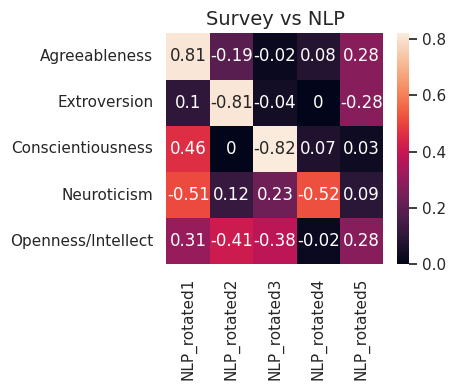

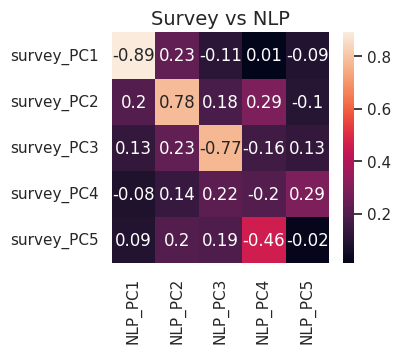

In [ ]:
#factorize the word embeddings, first with varimax rotation
n = 5
cols_nlp_rotated = ["NLP_rotated" + str(i+1) for i in range(n)]
factors, reducer, ev = factorize(vec, n_components = n, method = "FA", scaler = True)
df[cols_nlp_rotated] = factors

print(f"First {len(ev)} eigenvalues: {ev.round(3).tolist()}")
#print(ev)

#now without varimax rotation
cols_nlp_pc = ["NLP_PC" + str(i+1) for i in range(n)]
factors, reducer, ev = factorize(vec, n_components = n, method = "PCA", scaler = True)
df[cols_nlp_pc] = factors

#display correlations with survey results
corr = df[cols_nlp_rotated + cols_big5].corr().loc[cols_big5, cols_nlp_rotated]
heatmap(corr,title = "Survey vs NLP")

corr = df[cols_nlp_pc + cols_survey_pc[:n]].corr().loc[cols_survey_pc[:n], cols_nlp_pc]
heatmap(corr,title = "Survey vs NLP")

In [ ]:
_ = topk_words(df[cols_nlp_pc], k = 20)

,Positive Loading,Negative Loading
NLP_PC1,"[intolerant, uncooperative, inconsiderate, abusive, rude, disrespectful, bigoted, prejudiced, unfriendly, belligerent, crabby, unkind, surly, ungracious, callous, unsympathetic, uncharitable, quarrelsome, irritable, cruel]","[warm, sincere, kind, generous, down-to-earth, amiable, helpful, friendly, honest, considerate, pleasant, understanding, trustful, genial, courteous, charitable, easygoing, compassionate, cheerful, polite]"
NLP_PC2,"[unexcitable, unadventurous, uninquisitive, humorless, unambitious, passionless, dull, reserved, bland, unemotional, sedate, uncommunicative, silent, restrained, meek, passive, docile, formal, somber, quiet]","[impetuous, rambunctious, excitable, reckless, boisterous, explosive, impulsive, zealous, flamboyant, foolhardy, unrestrained, extravagant, rash, daring, outspoken, animated, boastful, opportunistic, flirtatious, exhibitionistic]"
NLP_PC3,"[gullible, lax, suggestible, careless, sloppy, naive, wishy-washy, unintelligent, meek, lazy, forgetful, aimless, shallow, unintellectual, frivolous, haphazard, nonpersistent, unambitious, absent-minded, indulgent]","[exacting, strict, unforgiving, stern, decisive, firm, deliberate, serious, tough, critical, unemotional, precise, ruthless, unsympathetic, scrupulous, rigid, principled, unaffectionate, formal, stubborn]"
NLP_PC4,"[melancholic, religious, fretful, superstitious, introspective, fearful, contemplative, sentimental, anxious, philosophical, emotional, masochistic, indecisive, nervous, introverted, finicky, subjective, dependent, complex, moody]","[unemotional, boastful, unsympathetic, bullheaded, smug, unintellectual, conceited, direct, condescending, pompous, uninquisitive, unaffectionate, inconsiderate, ungracious, straightforward, nonchalant, uncharitable, shallow, careless, bland]"
NLP_PC5,"[vague, haphazard, nonconforming, aimless, unconventional, nonpersistent, weariless, autonomous, abrupt, concise, unrestrained, inarticulate, unpredictable, bland, subjective, unexcitable, unimaginative, impersonal, nonchalant, irreverent]","[patronizing, abusive, jealous, considerate, charitable, bigoted, prejudiced, greedy, dishonest, manipulative, altruistic, self-pitying, understanding, deceitful, benevolent, helpful, compassionate, courteous, inconsiderate, condescending]"


In [ ]:
_ = topk_words(df[cols_survey_rotated], k = 50)

,Positive Loading,Negative Loading
survey_rot1,"[kind, sympathetic, cooperative, warm, understanding, patient, courteous, considerate, helpful, tolerant, polite, respectful, sincere, pleasant, charitable, compassionate, trustful, peaceful, agreeable, cordial, affectionate, reasonable, cheerful, loyal, thoughtful, flexible, generous, merry, obliging, amiable, friendly, jovial, reliable, sentimental, easygoing, mannerly, genial, optimistic, modest, accommodating, humble, honest, sensitive, dependable, undemanding, unselfish, responsible, adaptable, moral, relaxed]","[antagonistic, harsh, cold, rude, abusive, egotistical, inconsiderate, quarrelsome, unsympathetic, belligerent, scornful, bitter, abrupt, insincere, negativistic, cranky, combative, coarse, greedy, faultfinding, irritable, intolerant, callous, ruthless, grumpy, domineering, demanding, cruel, uncharitable, impolite, unkind, rough, stubborn, impersonal, cynical, conceited, critical, uncooperative, egocentric, unforgiving, argumentative, bigoted, bossy, boastful, crabby, suspicious, bullheaded, impatient, temperamental, insensitive]"
survey_rot2,"[shy, silent, withdrawn, introverted, timid, quiet, bashful, reserved, unaggressive, inhibited, unsociable, meek, passive, uncommunicative, restrained, dull, bland, submissive, melancholic, sedate, somber, cowardly, insecure, self-pitying, unadventurous, indirect, uncompetitive, pessimistic, unfriendly, negativistic, sluggish, cautious, nonpersistent, detached, placid, docile, indecisive, fearful, modest, vague, fretful, serious, wishy-washy, secretive, aloof, prudish, nervous, unimaginative, unambitious, lethargic]","[extroverted, aggressive, talkative, assertive, bold, sociable, social, verbal, confident, outspoken, dominant, daring, magnetic, communicative, spirited, enthusiastic, energetic, assured, uninhibited, rambunctious, unrestrained, domineering, active, forceful, boisterous, vivacious, vigorous, merry, adventurous, expressive, flamboyant, courageous, playful, direct, happy-go-lucky, cheerful, straightforward, mischievous, friendly, carefree, competitive, jovial, frank, spontaneous, brave, enterprising, flirtatious, exhibitionistic, gregarious, opportunistic]"
survey_rot3,"[organized, responsible, precise, thorough, self-disciplined, practical, efficient, systematic, dependable, orderly, reliable, logical, steady, concise, consistent, careful, decisive, exacting, prompt, mature, rational, economical, meticulous, purposeful, industrious, punctual, controlled, alert, firm, cautious, dignified, thrifty, wise, mannerly, conscientious, foresighted, respectful, perfectionistic, reasonable, formal, ambitious, polite, objective, knowledgeable, serious, strict, principled, discreet, sophisticated, analytical]","[disorganized, haphazard, careless, impractical, disorderly, inconsistent, unreliable, inefficient, illogical, absent-minded, immature, scatterbrained, negligent, erratic, undependable, reckless, indecisive, sloppy, unstable, lazy, forgetful, foolhardy, impulsive, aimless, lax, wishy-washy, rash, wasteful, frivolous, insecure, inconsiderate, compulsive, gullible, disrespectful, vague, unruly, thoughtless, unambitious, dishonest, rebellious, unconventional, hypocritical, impolite, gossipy, restless, tactless, indiscreet, unobservant, lustful, nosy]"
survey_rot4,"[unemotional, masculine, unexcitable, relaxed, undemanding, patient, courageous, insensitive, brave, easygoing, informal, passionless, confident, consistent, assured, steady, tolerant, rough, unaffectionate, tough, nonchalant, unsympathetic, impolite, clever, unassuming, logical, rational, peaceful, independent, down-to-earth, nonreligious, earthy, disrespectful, versatile, weariless, nonconforming, decisive, wise, ingenious, uncouth, casual, smart, ungracious, unkind, unsophisticated, enterprising, inventive, controlled, hearty, uninhibited]","[emotional, touchy, moody, temperamental, jealous, fretful, possessive, envious, feminine, irritable, sentimental, nervo

In [ ]:
df.loc[['extroverted','introverted','agreeable','domineering'], cols_survey_rotated]

,survey_rot1,survey_rot2,survey_rot3,survey_rot4,survey_rot5
extroverted,0.024107,-0.150967,-0.015670,-0.003904,-0.008502
introverted,-0.006669,0.152867,0.006981,0.001987,-0.015306
agreeable,0.115805,0.022794,0.014448,0.014289,0.000620
domineering,-0.093316,-0.101549,0.016849,-0.007817,0.004737


The first three NLP factors (with or without varimax rotation) are quite similar to the survey results. In the second figure the correlations come very close to a diagonal matrix (for the first three PCs). In the first figure, NLP_FA1 loads on Conscientiousness and Neuroticism as well as Agreeableness.

The eigenvalues start out large and drop off quickly, particularly after the third factor (four is 50% smaller).

# Study 3: Sensitivity Analysis #

Having established that the proposed NLP method can find signal, we explore the effects of changing:
 * Adjective set
 * Query
 * Language Model

 Going foreword results will be reported using PCA without varimax rotation. This simplifies interpreting structure, particularly when we are concerned with the number of factors needed to represent general personality.


###word set

In [ ]:
#load other words

#2700 words and whether they are in each of 4 different sets of adjectives
df1 = pd.read_table("https://raw.githubusercontent.com/andcut/DeepLexicalHypothesis/main/word_lists.csv", sep = ",")
df1[['G&N1710',"Webster83","S&G435"]] = df1[['G&N1710',"Webster83","S&G435"]].astype(bool)

#the entire set built by Condon
adj_condon = list(df1.TERM.values)

#the subset by Goldberg and Norman used for several papers
adj_1700 = list(df1[df1['G&N1710']].TERM.values)

#merriam webster list of basic personality adjectives
adj_webster = list(df1[df1["Webster83"]].TERM.values)

#add big_5 info on the 435 to the main df
df1 = df1.set_index("TERM")
df1.index = [word.lower() for word in df1.index]

#join them with the main dataframe
df = df1.join(df, how = "outer")

#Also loadthe 18k Allport words to play with if you like
dfAO = pd.read_table("https://raw.githubusercontent.com/andcut/DeepLexicalHypothesis/main/AllportOdbert_adjectives.csv", sep = ",").set_index('TDATN')
dfAO.index = [word.lower() for word in dfAO.index.astype(str)]
df_wordsets = df[['G&N1710',	'S&G435',	'Webster83']].join(dfAO['Allport Odbert source'], how = 'outer')

In [ ]:
#vectorize all words
cols_vec = ['E'+str(i) for i in range(1024)]
df[cols_vec] = np.nan

sentences = [f"Those close to me say I have a {mask_token}{mask_token} and {word} personality." for word in df.index]
vec = embed_w_batches(sentences, tokenizer, model, device, mask = True,
                      batch_size = models[model_name][2], verbose = False)
df[cols_vec] = vec

In [ ]:
#factor each wordset
#use webster, 435, 1710
n = 5
set_info = {
    "webster" : {"idx": df['Webster83']},
    "435" : {"idx" : df["S&G435"]},
    "1710": {"idx": df["G&N1710"]},
    "condon" : {"idx": [True]*len(df)}
}

for name in set_info:
  print(f"Starting to factorize {name} adjectives.")

  #name the 5 factor columns for each set
  set_info[name]["cols"] =  [name + "_" + str(i + 1) for i in range(n)]
  vec = df.loc[set_info[name]['idx'], cols_vec]

  #factorize
  factors, reducer, EV = factorize(vec, method = "PCA", n_components = n)
  set_info[name]['factors'] = factors
  set_info[name]['reducer'] = reducer
  set_info[name]['EV'] = EV

  print(EV.round(3))

#add factors to the df
for name in set_info:
  if "factors" in list(set_info[name].keys()):
    df.loc[set_info[name]["idx"], set_info[name]["cols"]] = set_info[name]["factors"]

Starting to factorize webster adjectives.
[0.268 0.147 0.092 0.06  0.046 0.036 0.029 0.028 0.024 0.023]
Starting to factorize 435 adjectives.
[0.226 0.143 0.089 0.048 0.047 0.034 0.03  0.029 0.022 0.021]
Starting to factorize 1710 adjectives.
[0.189 0.13  0.081 0.057 0.044 0.035 0.034 0.03  0.022 0.021]
Starting to factorize condon adjectives.
[0.185 0.12  0.077 0.051 0.047 0.037 0.031 0.03  0.025 0.022]


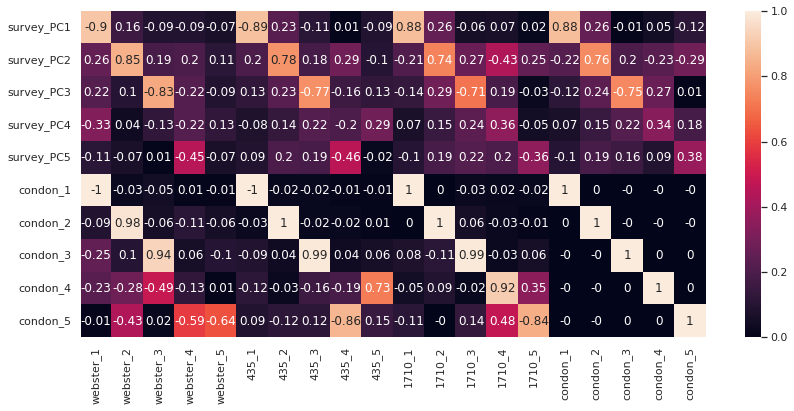

In [ ]:
cols_wordset= []
for name in set_info:
  cols_wordset += set_info[name]["cols"][:5]

cols_reference = cols_survey_pc[:5] + set_info["condon"]["cols"][:5]
corr = df[cols_wordset + cols_survey_pc[:5]].corr().loc[cols_reference, cols_wordset]
heatmap(corr)

The most surprising result is how little the word set matters. There are differences in structure. For example, Webster (n = 87) correlates very little with any of the Big Five after the third PC. The information in larger sets takes more factors to represent: 18.5% vs 26.8% of variance explained by the first PC.

However, the Webster set has the highest correlation with Extroversion, Conscientiousness and Neuroticism. The latter correlation occurs on the first rather than fourth factor, but the information is there.

Comparing the NLP results to the condon set, it's clear that there is very little difference on the first three factors. While good news that the structure is stable (a central tenant of the Big Few), one may expect more difference the scant 84 "core personality words" collected by Merriam-Webster than the 2700 collected by Condon with an eye to methodically mapping personality. The comparative non-importance of word set may be explained by the query strategy. Each word acts as a kind of seed for the mask_token, which the model can fill in with any descriptor in its very large vocabulary.

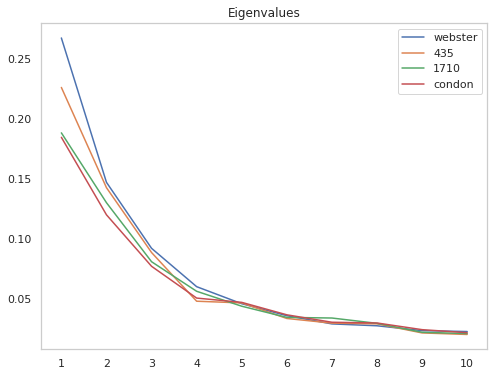

In [ ]:
#plot the eigenvalues
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid", {'axes.grid' : False})

for name in set_info:
  sns.lineplot(x = range(1,11), y = set_info[name]["EV"])

plt.legend(set_info)
plt.xticks(range(1,11))
plt.title("Eigenvalues")
plt.show()

In [ ]:
ev_435 = round(np.sum(set_info["435"]["EV"][:3])*100,1)
ev_survey_sum = round(np.sum(ev_survey[:3])*100,1)
print(f"The first three PCs in the 435 word set explain {ev_435}% of the variance.")
print(f"Compare this to {ev_survey_sum}% on the survey data.")

The first three PCs in the 435 word set explain 45.8% of the variance.
Compare this to 17.0% on the survey data.


NLP correlation matrix is much lower rank, more can be described with three factors. This is good for the Big Few theory that much of personality can be described with a few factors. It may be driven by how noisy survey data is, where every subject represent a dimension describing the word. An individual's report function is quite noisy, as evidenced by low test-retest reliability. This means that the dimensions used to describe the words are not stable. From the start of the test to the end someone may start feeling grumpy/hungry/bored (particularly after 400 words). Compare that to the NLP approach where every dimention is a defined by the model. There is no stochasticity; ask the model to embed that word again and you get the same answer. Further, ask them to embed a different word and the dimentions don't change meaning. A perfectly stable report function.

###Queries

The language model is trained to fill in blanks in sentences. If given the sentence "_____ is the greatest basketball player of all time" the model would return a probability distribution over the entire vocabulary (~50k words). "Jordan", "Lebron", "Michael" would all be highly weighted. There are many subtleties that effect the distribution. For example, if Michael Jordan is the better player, but Lebron is referred to more frequently by just just one name the model may return "Lebron". This is the most likely word to fill in the blank, but not necessarily an answer about the greatest basketball player.

We seek to develop a query that a) follows the spirit of surveys b) lets the model know that the word is being used as a personality descriptor. On the second point, "big" can mean many things. When used to describe a personality it means that person is loud, outspoken, and outgoing.

So to embed "cantankerous" we use phrases like: "those who know me well say I am a _____ and cantenkerous person", "I have a ____ and cantankerous personality", ...

We will use the 435 adjectives

In [ ]:
#define the queries
adjectives = adj_435
n_components = 5

q1 = [f"I tend to be {mask_token}{mask_token} and {word}." for word in adjectives]
q2 = [f"Those close to me say I have a {mask_token}{mask_token} and {word} personality." for word in adjectives]
q3 = [f"The girl's disposition became more {mask_token}{mask_token} and {word} as the years passed." for word in adjectives]
q4 = [f"My inlaws seem like {mask_token}{mask_token} and {word} folks." for word in adjectives]
q5 = [f"Met this guy and he's so {mask_token} and {word}. You would not believe!" for word in adjectives]
q6 = [f"My arch enemy's personality: {mask_token}, {mask_token} and {word}." for word in adjectives]
q7 = [f"A woman of contrasts: at times {mask_token}{mask_token}{mask_token}{mask_token} and at others perfectly {word}." for word in adjectives]
q8 = [f"When he felt most authentic he would adopt an {mask_token}{mask_token} and {word} persona." for word in adjectives]


Qs = [q1, q2, q3, q4, q5, q6, q7, q8]

#vectorize words
reducers = []
vecs = []
PCs = []
EVs = []
for q in Qs:
  print(q[0])
  vec = embed_w_batches(q,tokenizer, model, device,
                        batch_size = models[model_name][2])
  factors, reducer, ev = factorize(vec, n_components = n_components, method = "PCA")
  PCs += [factors]
  reducers += [reducer]
  EVs += [ev]
  vecs += [vec]

I tend to be [MASK][MASK] and abrupt.
Those close to me say I have a [MASK][MASK] and abrupt personality.
The girl's disposition became more [MASK][MASK] and abrupt as the years passed.
My inlaws seem like [MASK][MASK] and abrupt folks.
Met this guy and he's so [MASK] and abrupt. You would not believe!
My arch enemy's personality: [MASK], [MASK] and abrupt.
A woman of contrasts: at times [MASK][MASK][MASK][MASK] and at others perfectly abrupt.
When he felt most authentic he would adopt an [MASK][MASK] and abrupt persona.


Each query extracts idiosyncratic information from the model. Some may be more suitable for certain goals. It is perhaps the most artistic, creative step in the process. Here we explain some technical and linguistic considerations that went into the selection of this broad array of queries.

1.   ***I tend to be [MASK][MASK] and [WORD].*** This is meant to be a straightforward self-disclosure about typical disposition. The two masks allow more complex words (or pairs of words) to be used to fill in the blank. The mask tokens carry the information of *any* words that could be used in the blank; they capture meaning, not a specific instantiation.
2.   ***Those close to me say I have a [MASK][MASK] and [WORD] personality.*** This is a more intimate variation of self-disclosure about one's perceived characteristics according to close friends. Notice that preceding mask with "a" indicates the first word should not begin with a vowel, cutting out a percent of possible mask fillers. This constraint would be carried along in the "meaning".
3.   ***The girl's disposition became more [MASK][MASK] and [WORD] as the years passed.*** This is in the voice of a narrator or perhaps an adult that watched the child mature. It explicitly indicates disposition that is relatively stable (well, growing) across years. A gendered version works better than "the child's..". Possibly because the dryer, non-gendered version carries less valence. To make up for having to choose a gender, other queries use male. Given that the results can be concatenated and factored together, it is better to err on the side of rich, biased representations. Factoring these together can extract common structure, mitigating bias.
4.   ***My inlaws seem like [MASK][MASK] and [WORD] folks.*** This is a tepid judgement of an important but fairly formal familial relationship.
5.   ***Met this guy and he's so [MASK] and [WORD]. You would not believe!*** Going with the theory that valence matters, this is an impassioned judgement of an new relationship. The exclamatory "You would not believe!" helps extract a richer structure. Notice that most queries use double mask (which in general works best). This uses a single mask token which will limit what is filled in to fairly common (or short) words. Good to have *different* biases.
6.   ***My arch enemy's personality: [MASK], [MASK] and [WORD].*** This is in the tradition other reports including family, acquaintances, and enemies. It relies on punctuation to imply that the mask tokens are frequent co-travelers with the personality adjective. A comma-separated list allows two similar (short/common) descriptions to be used for each [WORD].
7.   ***A woman of contrasts: at times [MASK][MASK][MASK][MASK] and at others perfectly [WORD].*** This query implies that the masked phrase (four mask tokens back to back) is something that contrasts to [WORD]. The four masks allow the model to get creative. One can imagine "fit to tie" or similar idioms to contrast peaceful. "perfectly" acts as a valence increaser.
8.   ***When he felt most authentic he would adopt an [MASK][MASK] and [WORD] persona.*** This uses "an" instead of "a" and implies the "authentic" character of the subject.

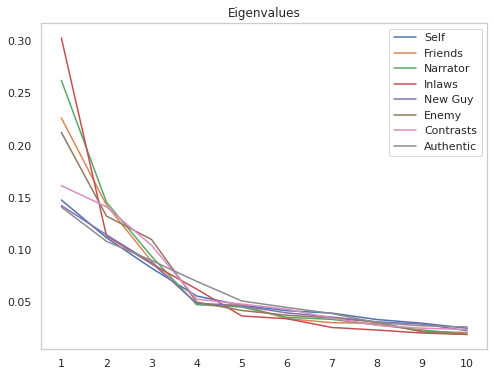

In [ ]:
#plot the eigenvalues
q_labels = ["Self", "Friends", "Narrator", "Inlaws", "New Guy", "Enemy", "Contrasts", "Authentic"]
sns.set(rc={'figure.figsize':(8,6)})
sns.set_style("whitegrid", {'axes.grid' : False})

for ev in EVs:
  x = range(1,len(ev)+1)
  sns.lineplot(x = x, y = ev)

plt.legend(q_labels)
plt.xticks(x)
plt.title("Eigenvalues")
plt.show()

EV:  [0.183 0.122 0.091 0.044 0.04  0.034 0.032 0.027 0.021 0.02 ]


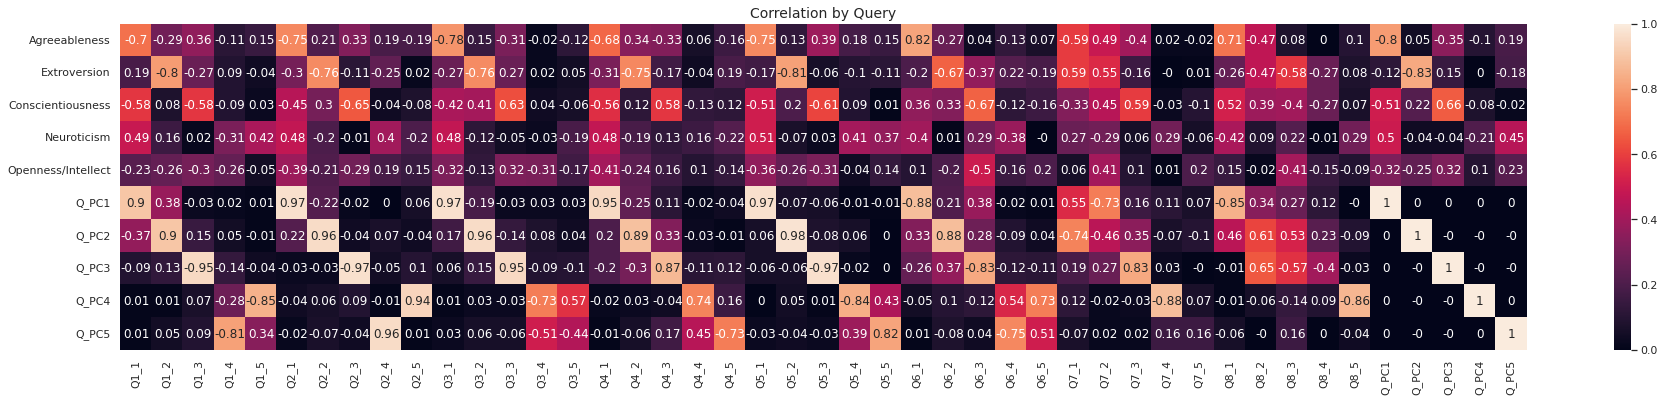

In [ ]:
###display correlations###

#make dataframe of all PCs
df_q = pd.DataFrame(PCs[0], index = adjectives, columns = ["Q1_" + str(i+1) for i in range(n_components)])
df_vec = pd.DataFrame(vecs[0], index = adjectives)
for i in range(2,len(reducers) + 1):
  d = vecs[0].shape[-1]
  df_vec = df_vec.join(pd.DataFrame(vecs[i-1], index = adjectives, columns = [j + (i-1)*d for j in range(d)]), how = "outer")
  df_q[["Q" + str(i) + "_" + str(j+1) for j in range(n_components)]] = PCs[i-1]

df_vec.to_csv("study3_queries.csv")

#do PCA on all the embeddings concatenated together
factors, mega_reducer, ev = factorize(df_vec.values, method = "PCA", scaler = True)
print("EV: ", ev.round(3))
df_q[["Q_PC" + str(i+1) for i in range(5)]] = factors

#compare every query to the concatenated result
cols_queries = list(df_q.columns)
df[cols_queries] = df_q
corr = df[cols_queries + cols_big5].corr().loc[cols_big5 + cols_queries[-5:], cols_queries]
heatmap(corr, title = "Correlation by Query")

In [ ]:
_ = topk_words(df[cols_queries[-5:]], k = 20)

,Positive Loading,Negative Loading
Q_PC1,"[abusive, belligerent, disrespectful, rude, intolerant, unkind, quarrelsome, bigoted, inconsiderate, vindictive, uncooperative, ungracious, surly, antagonistic, cruel, prejudiced, crabby, irritable, impolite, scornful]","[considerate, courteous, kind, pleasant, polite, respectful, agreeable, cordial, benevolent, helpful, cooperative, peaceful, compassionate, accommodating, amiable, understanding, genial, reasonable, generous, friendly]"
Q_PC2,"[unexcitable, unadventurous, humorless, passionless, uninquisitive, uncommunicative, dull, reserved, unambitious, somber, bland, withdrawn, silent, restrained, introverted, unsociable, meek, unemotional, quiet, lethargic]","[boisterous, rambunctious, excitable, flamboyant, impetuous, enthusiastic, energetic, vivacious, spirited, animated, bold, adventurous, outspoken, daring, gregarious, flirtatious, talkative, spontaneous, active, reckless]"
Q_PC3,"[exacting, decisive, strict, stern, serious, firm, deliberate, shrewd, precise, purposeful, analytical, unemotional, unforgiving, tough, forceful, critical, demanding, systematic, scrupulous, assertive]","[lax, gullible, meek, wishy-washy, naive, suggestible, unintelligent, frivolous, bashful, unambitious, lazy, careless, unintellectual, haphazard, sloppy, unsophisticated, forgetful, immature, absent-minded, shallow]"
Q_PC4,"[haphazard, aimless, nonconforming, unrestrained, unexcitable, inarticulate, nonchalant, uninhibited, nonpersistent, vague, concise, unconventional, spontaneous, restless, individualistic, autonomous, casual, vigorous, uncommunicative, unpredictable]","[considerate, bigoted, charitable, abusive, greedy, prejudiced, patronizing, dishonest, cruel, jealous, deceitful, altruistic, manipulative, compassionate, benevolent, helpful, condescending, sympathetic, kind, generous]"
Q_PC5,"[fretful, melancholic, introspective, contemplative, superstitious, sentimental, emotional, philosophical, anxious, nervous, finicky, fearful, complex, touchy, indecisive, moody, subjective, religious, introverted, artistic]","[unemotional, unsympathetic, unintellectual, straightforward, bland, direct, inconsiderate, thoughtless, nonchalant, passionless, uninquisitive, ungracious, shallow, bullheaded, impersonal, unassuming, unaffectionate, casual, coarse, boastful]"


###language models

In [ ]:
cols_dict = {}
PC_dict = {}

In [ ]:
model_names = ["bert-l","bert-whole-word", #two same-size versions of bert
               "deberta-b","deberta-l","deberta-xl","deberta-xl-mnli", #deberta series (different training objective)
               "roberta-l", "mp-net", "bart","span",  #several different LM training objectives
               "muppet", "toxic", #fine-tuned on different tasks (as is deberta-xl-mnli)
               "bert-clinical","tweet", #trained on clinical notes and tweets
               "xlm", #trained on multiple languages
               "mobile", "theseus"] #designed to be "small"

adjectives = adj_435
adj_col = 'S&G435'
df_models = df.loc[adj_435, cols_big5].copy()

for model_name in model_names:
  #check to see if these model's output is already in the df

  if model_name not in set(PC_dict.keys()):
    print(f"Starting to find factors using the {model_name} language model.")
    #download model
    model = AutoModel.from_pretrained(models[model_name][0], output_attentions = False)
    tokenizer = AutoTokenizer.from_pretrained(models[model_name][1], use_fast=False)

    #move model to GPU (if available)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    memory_check()

    #grab the special mask token
    mask_token = tokenizer.mask_token

    #define the queries
    sentences = make_sentences(adjectives, subset = False)
    #sentences = [f"Those close to me say I have a {mask_token}{mask_token} and {word} personality." for word in adjectives]

    #embed and store
    vec = embed_w_batches(sentences, tokenizer, model, device, mask = True,
                          batch_size = models[model_name][2], verbose = True)

    vec = vec.reshape((len(adjectives), -1), order = 'F')

    #store embedding
    cols_model_vec = [model_name + str(i+1) for i in range(vec.shape[-1])]
    cols_dict[model_name] = cols_model_vec
    df_models[cols_model_vec] = vec

    #factorize and store
    factors, reducer, ev = factorize(vec, n_components = 5, method = "PCA", scaler = True)
    cols_model_pc = [model_name + "_PC_" + str(i+1) for i in range(5)]
    df_models[cols_model_pc] = factors
    PC_dict[model_name] = cols_model_pc

Starting to find factors using the bert-l language model.


Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Free Memory = 84.7 %
Sample: 0
Free Memory = 31.14 %
Sample: 256
Free Memory = 31.14 %
Sample: 512
Free Memory = 26.3 %
Sample: 768
Free Memory = 29.84 %
Sample: 1024
Free Memory = 47.13 %
Sample: 1280
Free Memory = 36.84 %
Sample: 1536
Free Memory = 29.84 %
Sample: 1792
Free Memory = 25.119999999999997 %
Sample: 2048
Free Memory = 26.3 %
Sample: 2304
Free Memory = 36.84 %
Sample: 2560
Free Memory = 25.119999999999997 %
Sample: 2816
Free Memory = 26.3 %
Sample: 3072
Free Memory = 29.84 %
Sample: 3328
Free Memory = 52.22 %
Elapsed time: 13.006428 seconds.

Starting to find factors using the bert-whole-word language model.


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Free Memory = 84.7 %
Sample: 0
Free Memory = 31.14 %
Sample: 256
Free Memory = 31.14 %
Sample: 512
Free Memory = 26.3 %
Sample: 768
Free Memory = 29.84 %
Sample: 1024
Free Memory = 47.13 %
Sample: 1280
Free Memory = 36.84 %
Sample: 1536
Free Memory = 29.84 %
Sample: 1792
Free Memory = 25.119999999999997 %
Sample: 2048
Free Memory = 26.3 %
Sample: 2304
Free Memory = 36.84 %
Sample: 2560
Free Memory = 25.119999999999997 %
Sample: 2816
Free Memory = 26.3 %
Sample: 3072
Free Memory = 29.84 %
Sample: 3328
Free Memory = 52.22 %
Elapsed time: 13.010675 seconds.

Starting to find factors using the deberta-b language model.


Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'config', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Free Memory = 84.7 %
Sample: 0
Free Memory = 22.720000000000002 %
Sample: 512
Free Memory = 19.259999999999998 %
Sample: 1024
Free Memory = 32.4 %
Sample: 1536
Free Memory = 15.329999999999998 %
Sample: 2048
Free Memory = 19.259999999999998 %
Sample: 2560
Free Memory = 13.56 %
Sample: 3072
Free Memory = 32.18 %
Elapsed time: 6.292281 seconds.

Starting to find factors using the deberta-l language model.


Some weights of the model checkpoint at microsoft/deberta-large were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'config', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Free Memory = 83.52000000000001 %
Sample: 0
Free Memory = 41.86 %
Sample: 128
Free Memory = 36.9 %
Sample: 256
Free Memory = 41.86 %
Sample: 384
Free Memory = 41.86 %
Sample: 512
Free Memory = 36.02 %
Sample: 640
Free Memory = 36.9 %
Sample: 768
Free Memory = 36.9 %
Sample: 896
Free Memory = 49.7 %
Sample: 1024
Free Memory = 49.11 %
Sample: 1152
Free Memory = 49.7 %
Sample: 1280
Free Memory = 49.7 %
Sample: 1408
Free Memory = 44.91 %
Sample: 1536
Free Memory = 46.160000000000004 %
Sample: 1664
Free Memory = 41.86 %
Sample: 1792
Free Memory = 34.22 %
Sample: 1920
Free Memory = 36.9 %
Sample: 2048
Free Memory = 36.02 %
Sample: 2176
Free Memory = 44.91 %
Sample: 2304
Free Memory = 42.33 %
Sample: 2432
Free Memory = 44.91 %
Sample: 2560
Free Memory = 36.9 %
Sample: 2688
Free Memory = 32.800000000000004 %
Sample: 2816
Free Memory = 34.22 %
Sample: 2944
Free Memory = 34.22 %
Sample: 3072
Free Memory = 36.9 %
Sample: 3200
Free Memory = 36.02 %
Sample: 3328
Free Memory = 36.9 %
Sample: 3456
Fr

Some weights of the model checkpoint at microsoft/deberta-xlarge were not used when initializing DebertaModel: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Free Memory = 75.25 %
Sample: 0
Free Memory = 36.68 %
Sample: 64
Free Memory = 33.68 %
Sample: 128
Free Memory = 27.74 %
Sample: 192
Free Memory = 34.910000000000004 %
Sample: 256
Free Memory = 33.68 %
Sample: 320
Free Memory = 33.68 %
Sample: 384
Free Memory = 33.68 %
Sample: 448
Free Memory = 34.910000000000004 %
Sample: 512
Free Memory = 27.74 %
Sample: 576
Free Memory = 26.0 %
Sample: 640
Free Memory = 33.68 %
Sample: 704
Free Memory = 27.74 %
Sample: 768
Free Memory = 33.68 %
Sample: 832
Free Memory = 27.74 %
Sample: 896
Free Memory = 48.04 %
Sample: 960
Free Memory = 42.93 %
Sample: 1024
Free Memory = 42.92 %
Sample: 1088
Free Memory = 45.29 %
Sample: 1152
Free Memory = 42.93 %
Sample: 1216
Free Memory = 45.29 %
Sample: 1280
Free Memory = 42.93 %
Sample: 1344
Free Memory = 42.93 %
Sample: 1408
Free Memory = 36.68 %
Sample: 1472
Free Memory = 42.92 %
Sample: 1536
Free Memory = 42.92 %
Sample: 1600
Free Memory = 38.06 %
Sample: 1664
Free Memory = 42.92 %
Sample: 1728
Free Memory = 

Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Free Memory = 75.06 %
Sample: 0
Free Memory = 36.69 %
Sample: 64
Free Memory = 33.62 %
Sample: 128
Free Memory = 27.74 %
Sample: 192
Free Memory = 34.910000000000004 %
Sample: 256
Free Memory = 33.62 %
Sample: 320
Free Memory = 33.62 %
Sample: 384
Free Memory = 33.62 %
Sample: 448
Free Memory = 34.910000000000004 %
Sample: 512
Free Memory = 27.74 %
Sample: 576
Free Memory = 25.990000000000002 %
Sample: 640
Free Memory = 33.62 %
Sample: 704
Free Memory = 27.74 %
Sample: 768
Free Memory = 33.62 %
Sample: 832
Free Memory = 27.74 %
Sample: 896
Free Memory = 48.05 %
Sample: 960
Free Memory = 42.93 %
Sample: 1024
Free Memory = 42.92 %
Sample: 1088
Free Memory = 45.269999999999996 %
Sample: 1152
Free Memory = 42.93 %
Sample: 1216
Free Memory = 45.269999999999996 %
Sample: 1280
Free Memory = 42.93 %
Sample: 1344
Free Memory = 42.93 %
Sample: 1408
Free Memory = 36.69 %
Sample: 1472
Free Memory = 42.92 %
Sample: 1536
Free Memory = 42.92 %
Sample: 1600
Free Memory = 37.980000000000004 %
Sample: 1

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Free Memory = 75.06 %
Sample: 0
Free Memory = 30.59 %
Sample: 256
Free Memory = 35.14 %
Sample: 512
Free Memory = 29.409999999999997 %
Sample: 768
Free Memory = 30.59 %
Sample: 1024
Free Memory = 45.440000000000005 %
Sample: 1280
Free Memory = 39.900000000000006 %
Sample: 1536
Free Memory = 35.14 %
Sample: 1792
Free Memory = 25.83 %
Sample: 2048
Free Memory = 29.409999999999997 %
Sample: 2304
Free Memory = 36.32 %
Sample: 2560
Free Memory = 24.65 %
Sample: 2816
Free Memory = 25.83 %
Sample: 3072
Free Memory = 29.409999999999997 %
Sample: 3328
Free Memory = 51.68000000000001 %
Elapsed time: 12.247570 seconds.

Starting to find factors using the mp-net language model.


Some weights of the model checkpoint at microsoft/mpnet-base were not used when initializing MPNetModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing MPNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

Free Memory = 84.67 %
Sample: 0
Free Memory = 70.04 %
Sample: 256
Free Memory = 70.04 %
Sample: 512
Free Memory = 68.02 %
Sample: 768
Free Memory = 68.61 %
Sample: 1024
Free Memory = 75.84 %
Sample: 1280
Free Memory = 71.27 %
Sample: 1536
Free Memory = 68.61 %
Sample: 1792
Free Memory = 67.23 %
Sample: 2048
Free Memory = 68.02 %
Sample: 2304
Free Memory = 71.27 %
Sample: 2560
Free Memory = 67.23 %
Sample: 2816
Free Memory = 68.02 %
Sample: 3072
Free Memory = 68.61 %
Sample: 3328
Free Memory = 78.10000000000001 %
Elapsed time: 5.609665 seconds.

Starting to find factors using the bart language model.


Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartModel: ['classification_head.dense.weight', 'classification_head.out_proj.weight', 'classification_head.dense.bias', 'classification_head.out_proj.bias']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Free Memory = 83.47 %
Sample: 0
Free Memory = 19.09 %
Sample: 256
Free Memory = 23.87 %
Sample: 512
Free Memory = 16.29 %
Sample: 768
Free Memory = 19.09 %
Sample: 1024
Free Memory = 36.370000000000005 %
Sample: 1280
Free Memory = 29.82 %
Sample: 1536
Free Memory = 23.87 %
Sample: 1792
Free Memory = 11.360000000000001 %
Sample: 2048
Free Memory = 16.29 %
Sample: 2304
Free Memory = 25.05 %
Sample: 2560
Free Memory = 10.18 %
Sample: 2816
Free Memory = 11.360000000000001 %
Sample: 3072
Free Memory = 16.29 %
Sample: 3328
Free Memory = 43.519999999999996 %
Elapsed time: 14.613391 seconds.

Starting to find factors using the span language model.


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Free Memory = 83.47 %
Sample: 0
Free Memory = 31.15 %
Sample: 256
Free Memory = 29.959999999999997 %
Sample: 512
Free Memory = 26.3 %
Sample: 768
Free Memory = 29.959999999999997 %
Sample: 1024
Free Memory = 45.95 %
Sample: 1280
Free Memory = 40.36 %
Sample: 1536
Free Memory = 26.3 %
Sample: 1792
Free Memory = 25.119999999999997 %
Sample: 2048
Free Memory = 25.119999999999997 %
Sample: 2304
Free Memory = 35.66 %
Sample: 2560
Free Memory = 25.119999999999997 %
Sample: 2816
Free Memory = 25.119999999999997 %
Sample: 3072
Free Memory = 29.959999999999997 %
Sample: 3328
Free Memory = 51.0 %
Elapsed time: 13.188602 seconds.

Starting to find factors using the muppet language model.


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/muppet-roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at facebook/muppet-roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task 

Free Memory = 84.7 %
Sample: 0
Free Memory = 30.61 %
Sample: 256
Free Memory = 35.17 %
Sample: 512
Free Memory = 29.43 %
Sample: 768
Free Memory = 30.61 %
Sample: 1024
Free Memory = 45.46 %
Sample: 1280
Free Memory = 39.92 %
Sample: 1536
Free Memory = 35.17 %
Sample: 1792
Free Memory = 25.86 %
Sample: 2048
Free Memory = 29.43 %
Sample: 2304
Free Memory = 36.35 %
Sample: 2560
Free Memory = 24.68 %
Sample: 2816
Free Memory = 25.86 %
Sample: 3072
Free Memory = 29.43 %
Sample: 3328
Free Memory = 51.7 %
Elapsed time: 12.174974 seconds.

Starting to find factors using the toxic language model.


Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Free Memory = 84.7 %
Sample: 0
Free Memory = 70.17 %
Sample: 256
Free Memory = 70.17 %
Sample: 512
Free Memory = 68.02 %
Sample: 768
Free Memory = 68.61 %
Sample: 1024
Free Memory = 75.84 %
Sample: 1280
Free Memory = 71.37 %
Sample: 1536
Free Memory = 68.61 %
Sample: 1792
Free Memory = 67.23 %
Sample: 2048
Free Memory = 68.02 %
Sample: 2304
Free Memory = 71.37 %
Sample: 2560
Free Memory = 67.23 %
Sample: 2816
Free Memory = 68.02 %
Sample: 3072
Free Memory = 68.61 %
Sample: 3328
Free Memory = 78.10000000000001 %
Elapsed time: 5.472837 seconds.

Starting to find factors using the bert-clinical language model.


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Free Memory = 89.61 %
Sample: 0
Free Memory = 48.4 %
Sample: 512
Free Memory = 45.97 %
Sample: 1024
Free Memory = 55.87 %
Sample: 1536
Free Memory = 45.08 %
Sample: 2048
Free Memory = 45.08 %
Sample: 2560
Free Memory = 45.08 %
Sample: 3072
Free Memory = 56.16 %
Elapsed time: 5.446208 seconds.

Starting to find factors using the tweet language model.


Downloading:   0%|          | 0.00/614 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Free Memory = 84.65 %
Sample: 0
Free Memory = 30.56 %
Sample: 256
Free Memory = 35.120000000000005 %
Sample: 512
Free Memory = 29.38 %
Sample: 768
Free Memory = 30.56 %
Sample: 1024
Free Memory = 45.440000000000005 %
Sample: 1280
Free Memory = 39.87 %
Sample: 1536
Free Memory = 35.120000000000005 %
Sample: 1792
Free Memory = 25.81 %
Sample: 2048
Free Memory = 29.38 %
Sample: 2304
Free Memory = 36.3 %
Sample: 2560
Free Memory = 24.63 %
Sample: 2816
Free Memory = 25.81 %
Sample: 3072
Free Memory = 29.38 %
Sample: 3328
Free Memory = 51.62 %
Elapsed time: 12.162055 seconds.

Starting to find factors using the xlm language model.


Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

Free Memory = 78.64 %
Sample: 0
Free Memory = 67.44 %
Sample: 64
Free Memory = 65.38000000000001 %
Sample: 128
Free Memory = 65.38000000000001 %
Sample: 192
Free Memory = 67.44 %
Sample: 256
Free Memory = 65.38000000000001 %
Sample: 320
Free Memory = 67.44 %
Sample: 384
Free Memory = 65.38000000000001 %
Sample: 448
Free Memory = 65.38000000000001 %
Sample: 512
Free Memory = 64.79 %
Sample: 576
Free Memory = 64.79 %
Sample: 640
Free Memory = 65.38000000000001 %
Sample: 704
Free Memory = 65.38000000000001 %
Sample: 768
Free Memory = 65.38000000000001 %
Sample: 832
Free Memory = 65.38000000000001 %
Sample: 896
Free Memory = 70.45 %
Sample: 960
Free Memory = 69.99 %
Sample: 1024
Free Memory = 69.99 %
Sample: 1088
Free Memory = 70.45 %
Sample: 1152
Free Memory = 70.00999999999999 %
Sample: 1216
Free Memory = 70.00999999999999 %
Sample: 1280
Free Memory = 68.52000000000001 %
Sample: 1344
Free Memory = 68.52000000000001 %
Sample: 1408
Free Memory = 67.56 %
Sample: 1472
Free Memory = 68.520000

Downloading:   0%|          | 0.00/847 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/140M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing MobileBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Free Memory = 79.38 %
Sample: 0
Free Memory = 57.29 %
Sample: 512
Free Memory = 53.779999999999994 %
Sample: 1024
Free Memory = 60.79 %
Sample: 1536
Free Memory = 53.290000000000006 %
Sample: 2048
Free Memory = 53.779999999999994 %
Sample: 2560
Free Memory = 53.290000000000006 %
Sample: 3072
Free Memory = 63.31 %
Elapsed time: 4.275502 seconds.

Starting to find factors using the theseus language model.


Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/151 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Free Memory = 90.8 %
Sample: 0
Free Memory = 71.16 %
Sample: 512
Free Memory = 68.8 %
Sample: 1024
Free Memory = 72.75 %
Sample: 1536
Free Memory = 68.36 %
Sample: 2048
Free Memory = 68.8 %
Sample: 2560
Free Memory = 68.36 %
Sample: 3072
Free Memory = 73.96000000000001 %
Elapsed time: 3.451886 seconds.



In [ ]:
#factorize them all together
cols_models = []
for name in model_names:
  cols_models += cols_dict[name]
len(cols_models)

df_models[cols_models] = df_models[cols_models].astype(np.float16)

In [ ]:
factors, reducer, ev = factorize(df_models[cols_models], method = "PCA", scaler = True)
cols_LM_PCs = ["LM" + str(i+1) for i in range(5)]
df_models[cols_LM_PCs] = factors

In [ ]:
df_models.to_csv("lots_of_models.csv")

In [ ]:
df_models[cols_survey_pc] = df[cols_survey_pc]

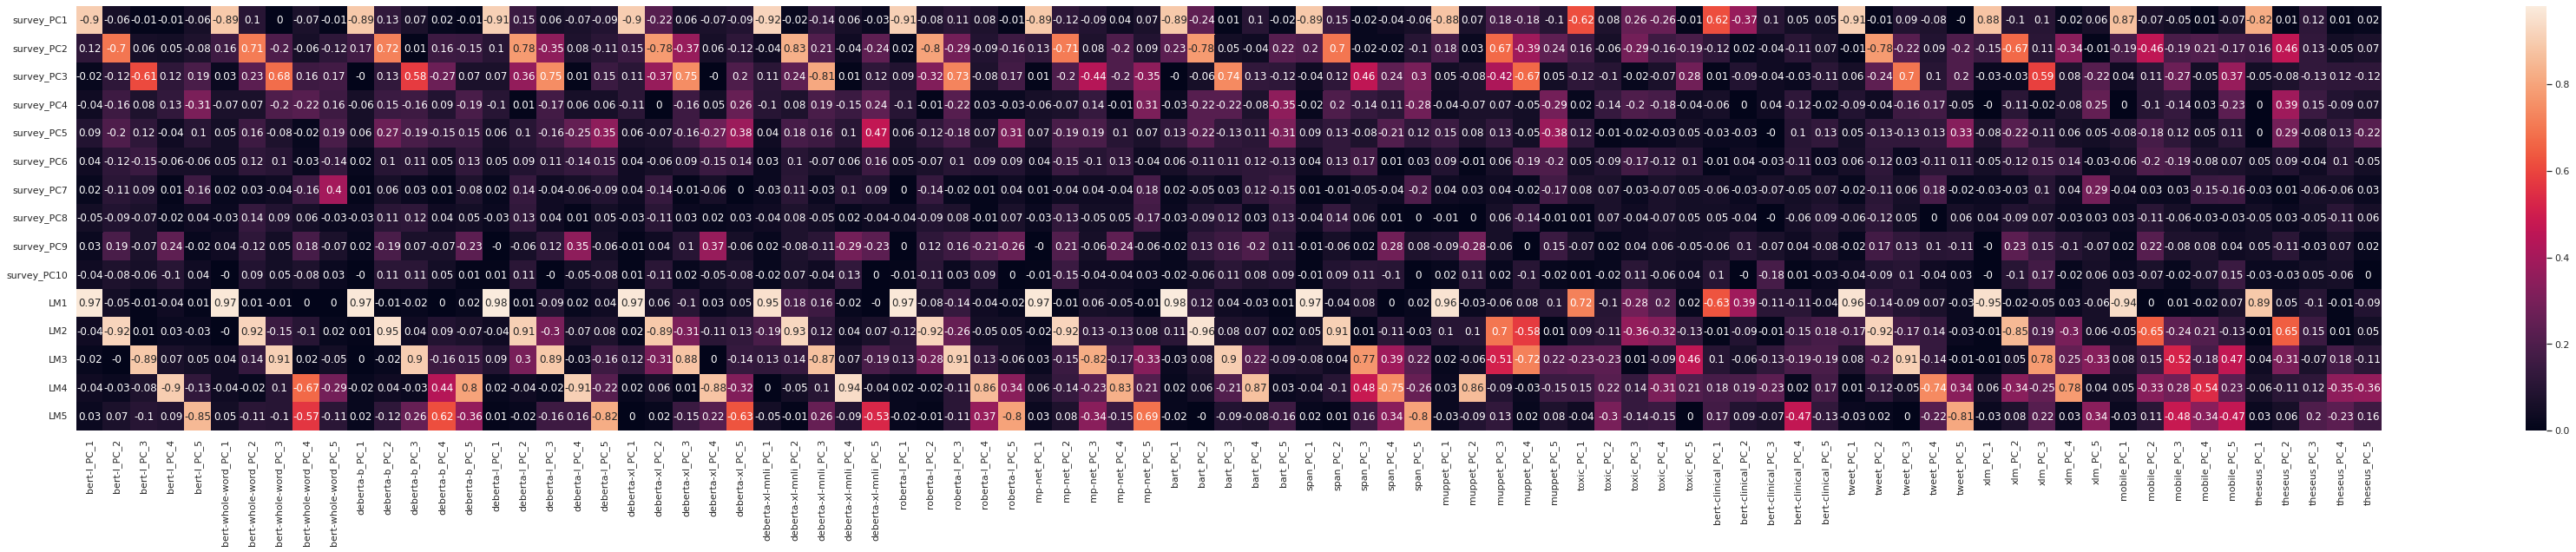

In [ ]:
#plot correlations
cols_LMs = []
for name in model_names:
  cols_LMs += PC_dict[name]
corr = df_models[cols_LM_PCs + cols_LMs].corr()
heatmap(corr.loc[cols_LM_PCs, cols_LMs])

##All together now
Considering the best options from these analysis, what structure is produced?

Use


*   435
*   deberta-l-mnli
*   all queries
*   10 unroted PCs

In [ ]:
#download language model from HuggingFace
model_name = "deberta-xl-mnli" #deberta-l-mnli gives same results way faster
model = AutoModel.from_pretrained(models[model_name][0], output_attentions = False)
tokenizer = AutoTokenizer.from_pretrained(models[model_name][1], use_fast=False)

Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['classifier.weight', 'pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#move model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
memory_check()

#grab the special mask token
mask_token = tokenizer.mask_token

Free Memory = 75.24 %


In [ ]:
adjectives = adj_435

sentences = make_sentences(adjectives, subset = False)
vec = embed_w_batches(sentences, tokenizer, model, device, mask = True,
                      batch_size = models[model_name][2], verbose = True)

vec = vec.reshape((len(adjectives), -1), order = 'F')

In [ ]:
df_all_together = pd.DataFrame(vec, index = adj_435)
df_all_together.to_csv("grand_finale.csv")

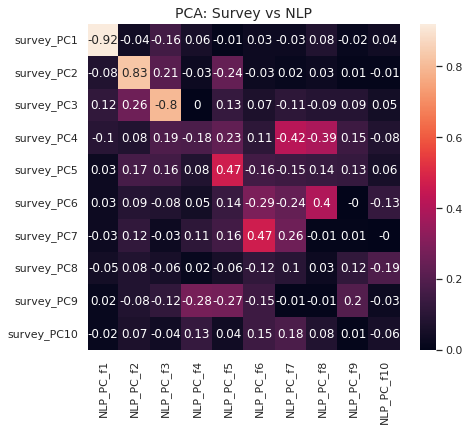

In [ ]:
cols_final_pc = ["NLP_PC_f" + str(i + 1) for i in range(10)]

factors, reducer, ev = factorize(vec, method = "PCA", scaler = True, n_components = 10)
df[cols_final_pc] = factors
corr = df[cols_final_pc +cols_survey_pc].corr()

heatmap(corr.loc[cols_survey_pc, cols_final_pc],title =  "PCA: Survey vs NLP")

[0.219 0.131 0.094 0.048 0.042 0.035 0.03  0.026 0.022 0.02 ]


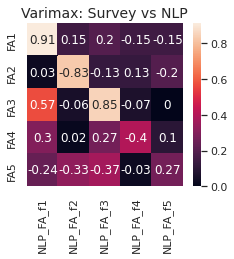

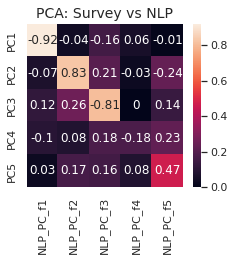

In [ ]:
cols_final_pc = ["NLP_PC_f" + str(i + 1) for i in range(5)]
cols_final_fa = ["NLP_FA_f" + str(i + 1) for i in range(5)]

factors, reducer, ev = factorize(vec, method = "PCA", scaler = True)
df.loc[idx,cols_final_pc] = factors
print(ev.round(3))

factors, reducer, ev = factorize(vec, method = "FA", scaler = True)
df.loc[idx, cols_final_fa] = factors

corr = df[cols_final_pc + cols_final_fa + cols_big5 + cols_pc].corr()

heatmap(corr.loc[cols_big5, cols_final_fa], title =  "Varimax: Survey vs NLP")
heatmap(corr.loc[cols_pc, cols_final_pc],title =  "PCA: Survey vs NLP")

## NLP and survey factor differences

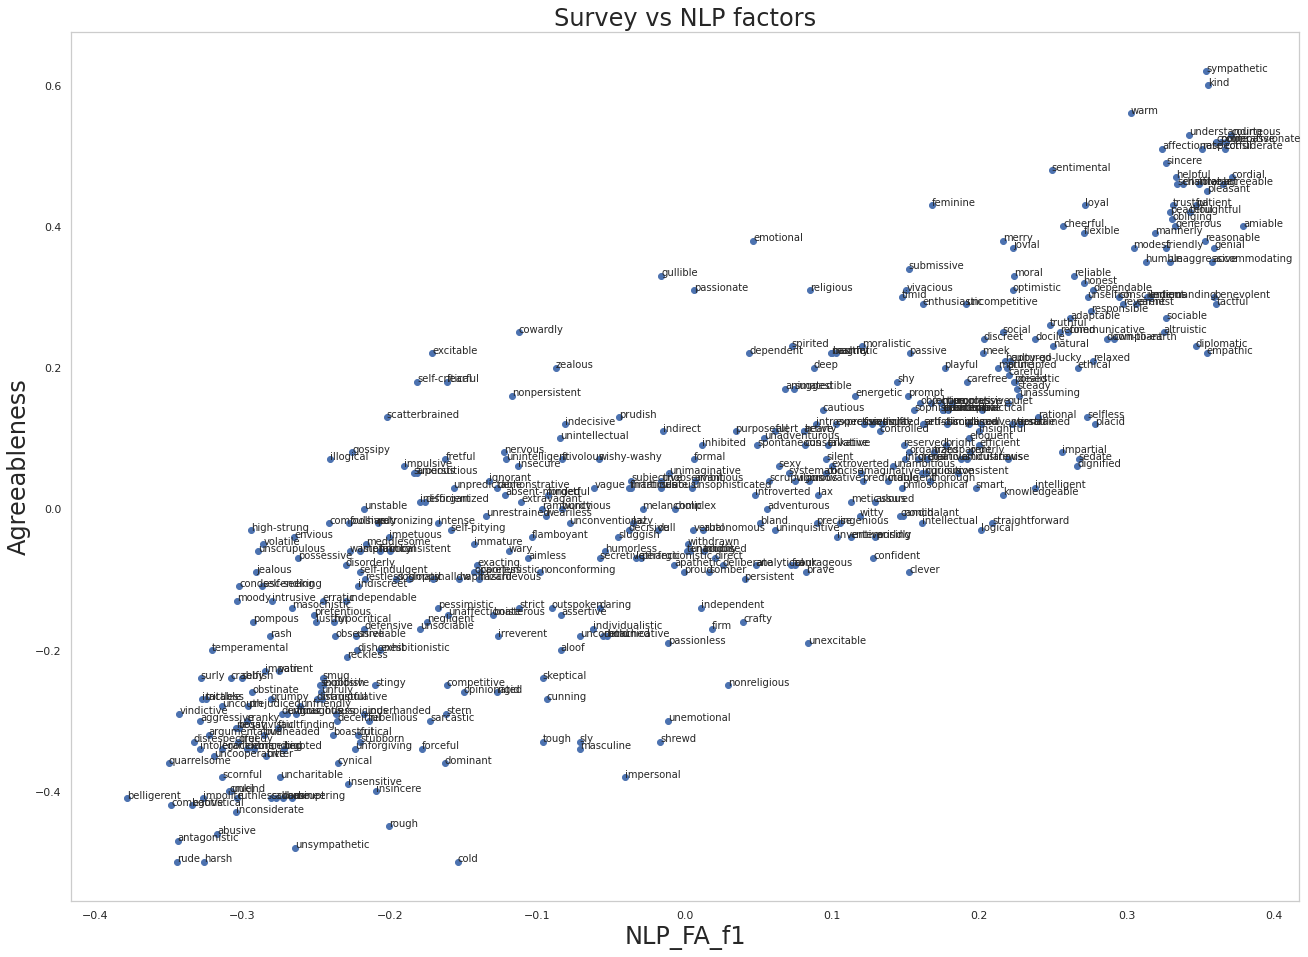

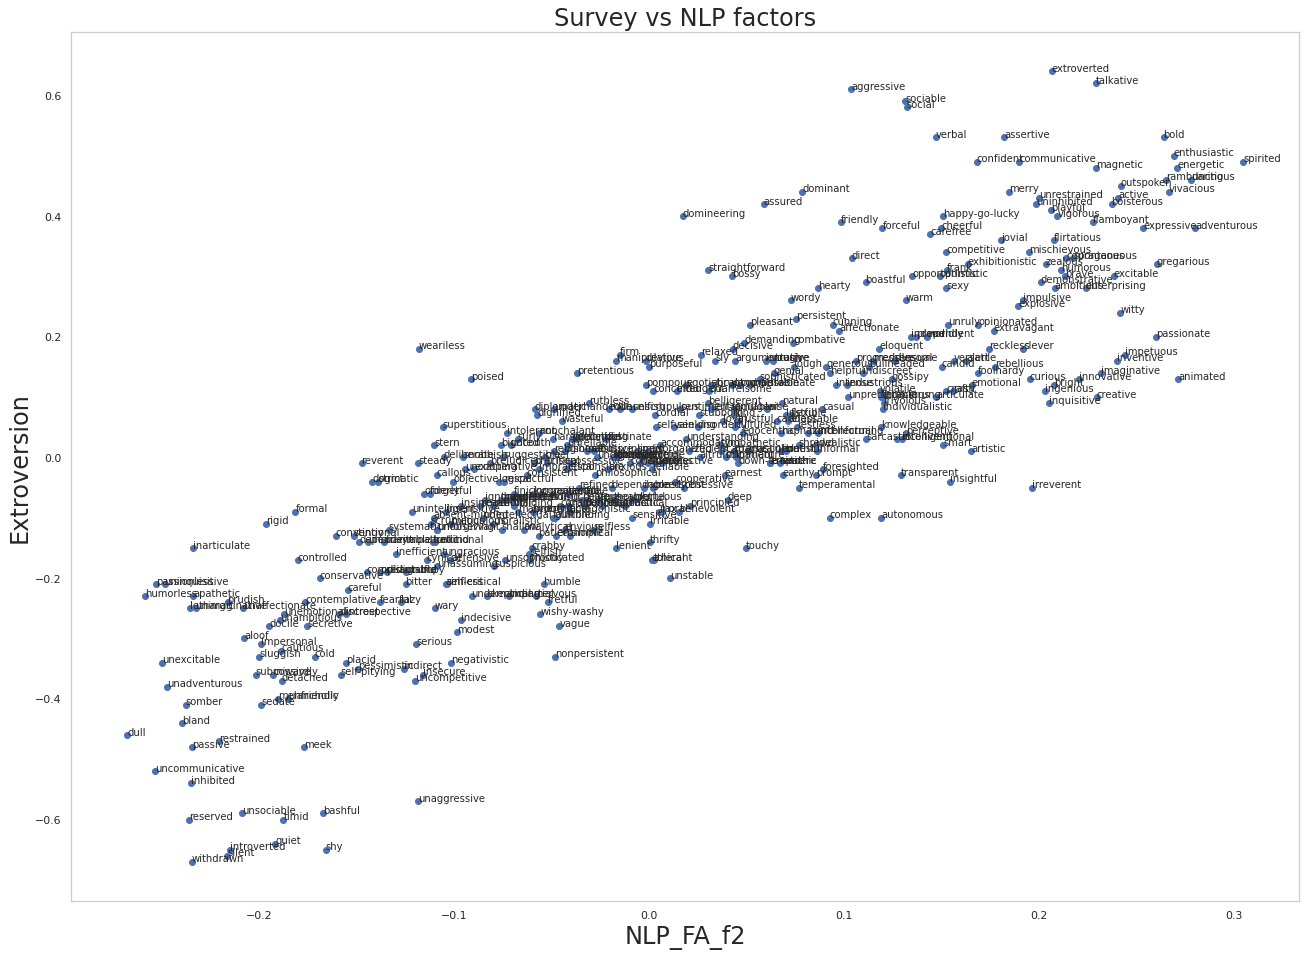

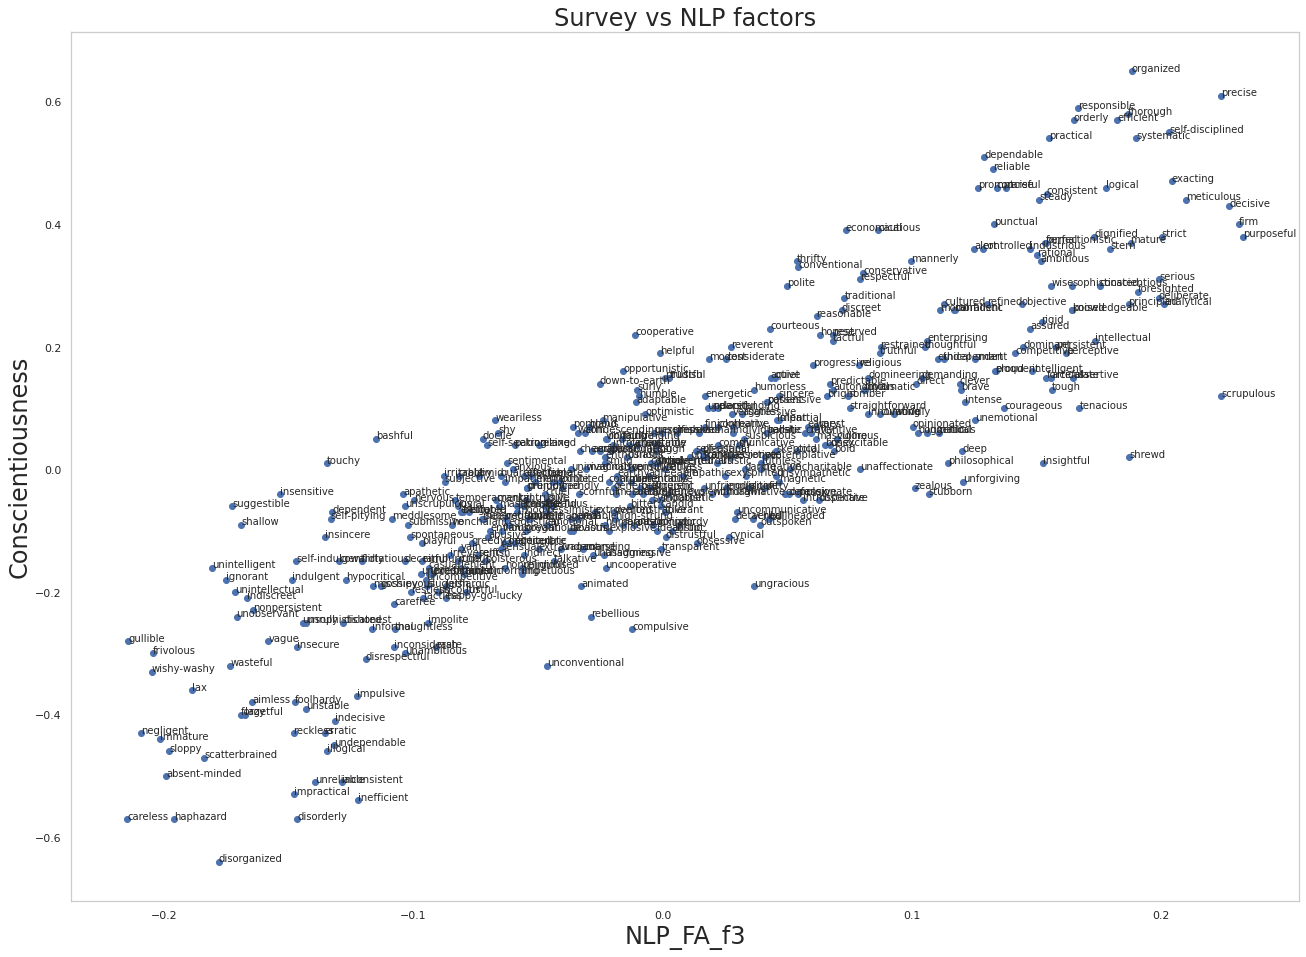

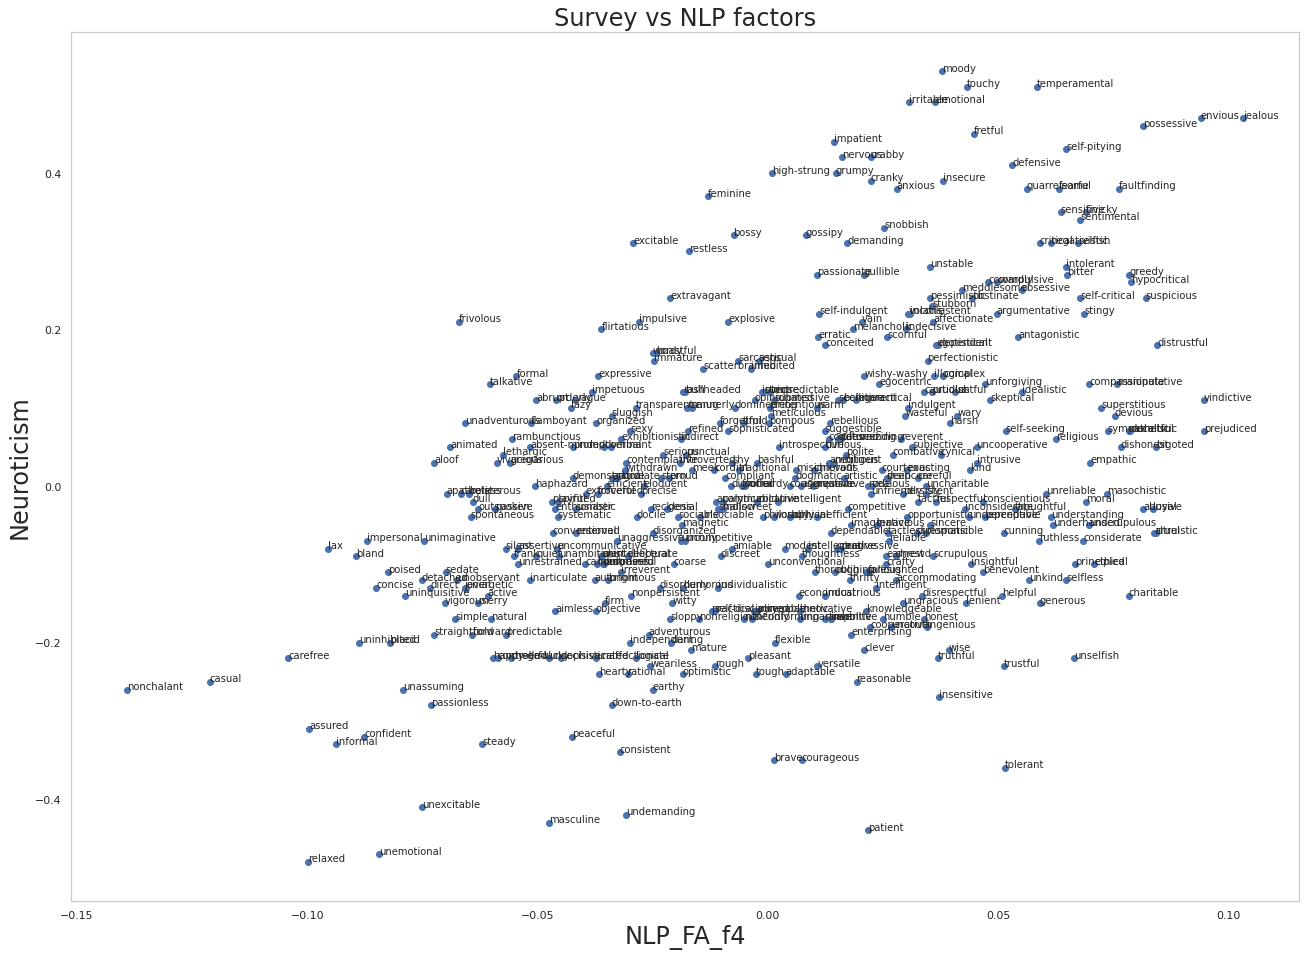

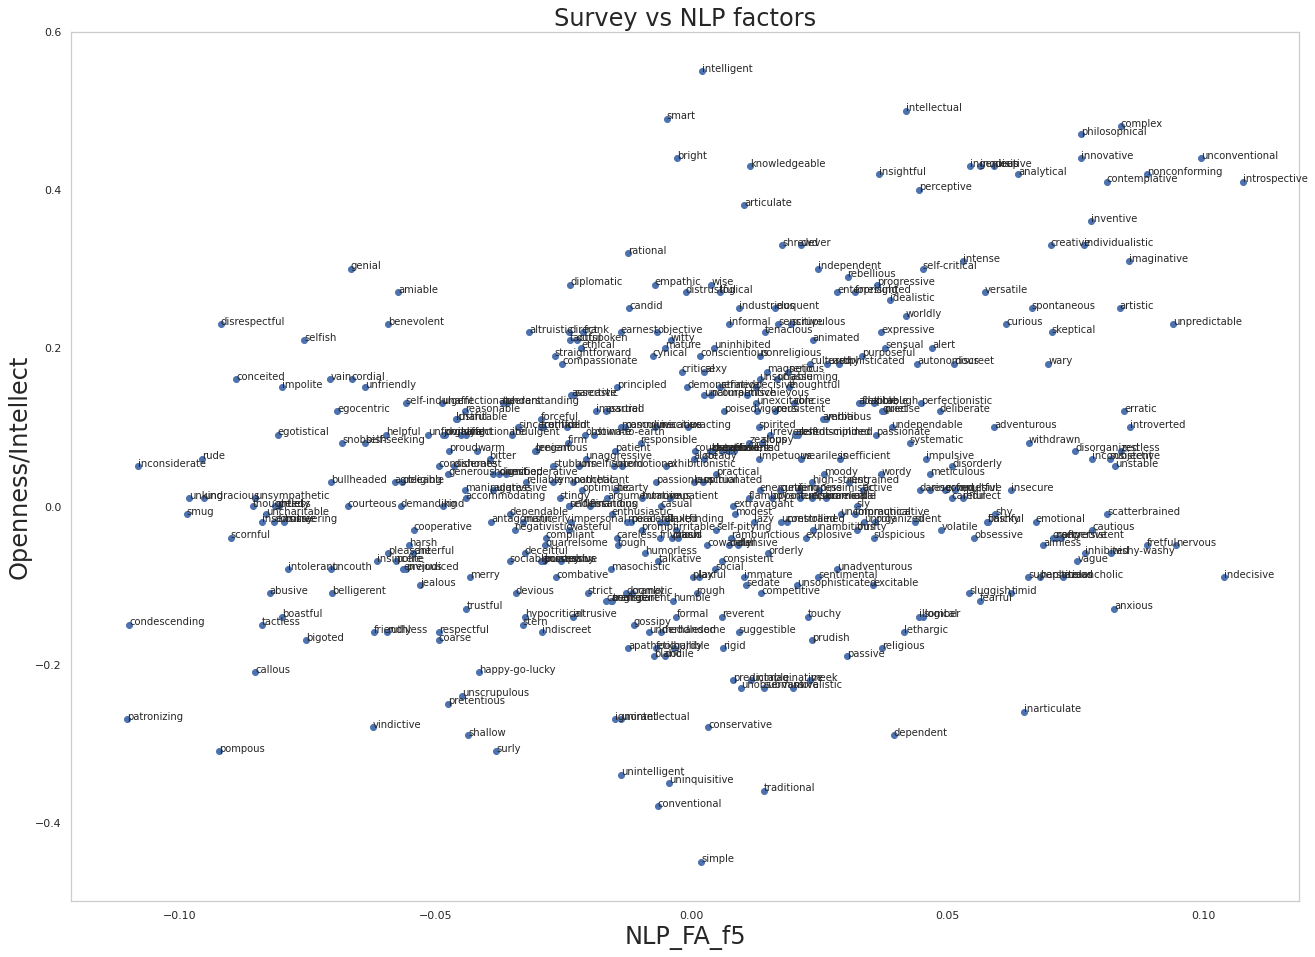

In [ ]:
#compare each of the NLP and survey factors
#first make sure every factor has the same sign
sign = np.sign(np.diag(corr.loc[cols_big5, cols_final_fa]))
df[cols_final_fa] = df[cols_final_fa]*sign
for i in range(5):
  plot_words(df[[cols_final_fa[i], cols_big5[i]]].dropna(), title = f"Survey vs NLP factors")

## Adjective nearest neighbors: survey vs NLP

In [ ]:
#which words don't match survey corrs?
scaler = StandardScaler()
df1 = df_models[cols_vec_final].copy()
df1[:] = scaler.fit_transform(df1)
df1 = df1.T.corr()

df1[:] = scaler.fit_transform(df1)

In [ ]:
df2 = df[cols_survey].T.corr()
df2[:] = scaler.fit_transform(df2)

corrs = []
for i in range(len(df1)):
  corrs.append(np.corrcoef(df1.iloc[i], df2.iloc[i])[0][1])

df3 = pd.DataFrame([corrs], columns=df1.columns, index = ['nlp_survey_corr']).T
df3 = df3.sort_values('nlp_survey_corr')
#different_words = list(df3.sum(axis = 0).sort_values().iloc[:10].index)
#df3.sum(axis = 0).sort_values().iloc[:30]

In [ ]:
df3.sort_values('nlp_survey_corr').iloc[:20]

,nlp_survey_corr
weariless,-0.122377
transparent,0.051907
natural,0.140111
naive,0.240743
self-critical,0.290973
nonreligious,0.330443
superstitious,0.356936
self-seeking,0.372139
irreverent,0.376770
touchy,0.402294


In [ ]:
def compare_methods(df_survey_corrs, df_NLP_corrs, words, congruence_list, k = 5):
  df = pd.DataFrame(index = words, columns = ["congruence", "survey_neighbors", "survey_opposites", "NLP_neighbors", "NLP_opposites"])
  for word in words:
    df.loc[word, 'survey_opposites'] = list(df_survey_corrs[word].sort_values(ascending = True).iloc[:k].index)
    df.loc[word, 'survey_neighbors'] = list(df_survey_corrs[word].sort_values(ascending = False).iloc[1:k+1].index)

    df.loc[word, 'NLP_opposites'] = list(df_NLP_corrs[word].sort_values(ascending = True).iloc[:k].index)
    df.loc[word, 'NLP_neighbors'] = list(df_NLP_corrs[word].sort_values(ascending = False).iloc[1:k+1].index)

  df['congruence'] = congruence_list
  return df

different_words = list(df3.iloc[:10].index)
congruences = df3.iloc[:10].nlp_survey_corr.values
df_comp = compare_methods(df2, df1, different_words, congruences, k = 5)
df_comp.to_csv("words_nlp_survey_disagreement.csv")
df_comp

,congruence,survey_neighbors,survey_opposites,NLP_neighbors,NLP_opposites
weariless,-0.122377,"[energetic, vigorous, courageous, hearty, bold]","[sluggish, lazy, lethargic, insecure, touchy]","[lethargic, sluggish, aimless, lazy, apathetic]","[communicative, articulate, witty, expressive,..."
transparent,0.051907,"[animated, gossipy, meek, unsophisticated, naive]","[knowledgeable, mature, logical, individualist...","[candid, frank, straightforward, truthful, hon...","[grumpy, uncooperative, snobbish, unsociable, ..."
natural,0.140111,"[earthy, down-to-earth, sincere, casual, infor...","[egotistical, hypocritical, faultfinding, anta...","[down-to-earth, casual, sincere, informal, tra...","[obstinate, intolerant, uncooperative, argumen..."
naive,0.240743,"[gullible, timid, inhibited, meek, scatterbrai...","[dominant, aggressive, domineering, wise, logi...","[gullible, ignorant, immature, unsophisticated...","[purposeful, exacting, decisive, forceful, dom..."
self-critical,0.290973,"[contemplative, introspective, sensitive, comp...","[confident, underhanded, assured, happy-go-luc...","[critical, faultfinding, self-pitying, finicky...","[genial, jovial, easygoing, amiable, casual]"
nonreligious,0.330443,"[irreverent, disrespectful, masculine, unchari...","[religious, reverent, moral, moralistic, tradi...","[religious, progressive, nonconforming, econom...","[forceful, demanding, intense, decisive, persi..."
superstitious,0.356936,"[sentimental, emotional, social, gossipy, magn...","[straightforward, unemotional, exacting, uncha...","[prudish, fearful, obsessive, prejudiced, fret...","[confident, articulate, efficient, pleasant, a..."
self-seeking,0.372139,"[opportunistic, egocentric, egotistical, self-...","[selfless, inarticulate, loyal, unsophisticate...","[egotistical, selfish, greedy, egocentric, con...","[patient, sedate, peaceful, placid, thoughtful]"
irreverent,0.376770,"[nonreligious, disrespectful, greedy, nonconfo...","[reverent, religious, moralistic, respectful, ...","[mischievous, sarcastic, rambunctious, rebelli...","[careful, restrained, conscientious, orderly, ..."
touchy,0.402294,"[temperamental, moody, irritable, defensive, g...","[relaxed, easygoing, patient, confident, uninh...","[sentimental, emotional, sensual, meddlesome, ...","[unemotional, self-disciplined, objective, una..."


Good case to be made for a 3 factor solution. Survey factors after three are recovered (with either PCA or varimax rotation), but not with a correlation greater than 0.5 (compared to 0.81-0.92 corelation of the first three). First two are very close to Digman's Big Two. Third is complementary. Whereas first is regulating self with respect to group, and second is described as self-actualization. Third is regulating self with respect to own future goals.

Eigenvalues also drop of after the third.

The scope of this paper is not to suggest a new general personality framework. There is still much work to do in perfecting and validating this method. But we do argue that Descriptive framworks based on the Lexical Hypothesis can be explanatory as well as descriptive. The preliminary three-factor result here succeeds on that basis.